# Sudoku
Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego
wyżarzania. Plansza 9 × 9 ma zostać wczytana z pliku tekstowego, w którym pola puste
zaznaczone są znakiem '.'. Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występujących w wierszach bloku 9 × 9, kolumnach bloku 9 × 9 oraz blokach 3 × 3. Zaproponuj
metodę generacji stanu sąsiedniego. Przedstaw zależność liczby iteracji algorytmu od
liczby pustych miejsc na planszy. Czy Twój program jest w stanie znaleźć poprawne
rozwiązanie dla każdej z testowanych konfiguracji wejściowych?


In [400]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import json

Definiujemy funkcje pomocnicze do wizualizacji plansz sudoku i animacji.

In [401]:
def visualize_sudoku_solving(sudoku_history, output_filename="sudoku_solving.gif", max_frames=100):
    """
    Tworzy animację procesu rozwiązywania Sudoku z ograniczoną liczbą klatek.

    :param sudoku_history: Lista kolejnych stanów planszy Sudoku.
    :param output_filename: Nazwa pliku wyjściowego GIF.
    :param max_frames: Maksymalna liczba klatek w animacji.
    """
    fig, ax = plt.subplots(figsize=(5, 5))  # Zmniejszono rozmiar figury

    # Rysowanie siatki raz na początku
    ax.set_xticks(np.arange(-0.5, 9, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 9, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    def update(frame):
        ax.clear()
        sudoku = sudoku_history[frame]
        previous_sudoku = sudoku_history[frame - 1] if frame > 0 else sudoku

        # Rysowanie planszy
        ax.imshow(sudoku, cmap="Pastel1", vmin=0, vmax=9)

        # Rysowanie cyfr i wyróżnianie zmienionych komórek
        for i in range(9):
            for j in range(9):
                color = "red" if sudoku[i, j] != previous_sudoku[i, j] else "black"
                if sudoku[i, j] != 0:
                    ax.text(j, i, str(sudoku[i, j]), ha="center", va="center", color=color)

        ax.set_title(f"Iteracja: {frame + 1}")

    # Ograniczenie liczby klatek do `max_frames`
    total_frames = len(sudoku_history)
    step = max(1, total_frames // max_frames)
    frames = range(0, total_frames, step)

    try:
        ani = FuncAnimation(fig, update, frames=frames, interval=100, repeat=False)
        writer = PillowWriter(fps=10)  # Zwiększono FPS dla płynności
        ani.save(output_filename, writer=writer)
        plt.close(fig)
        print(f"Animacja zapisana jako {output_filename}")
        return Image(output_filename)
    except Exception as e:
        print(f"Wystąpił błąd podczas tworzenia animacji: {e}")
        return None


def display_initial_and_best(initial_sudoku, best_sudoku):
    """
    Wyświetla początkową i najlepszą planszę Sudoku.

    :param initial_sudoku: Początkowa plansza Sudoku.
    :param best_sudoku: Najlepsza znaleziona plansza Sudoku.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Początkowa plansza
    axes[0].imshow(initial_sudoku, cmap="Pastel1", vmin=0, vmax=9)
    for i in range(9):
        for j in range(9):
            if initial_sudoku[i, j] != 0:
                axes[0].text(j, i, str(initial_sudoku[i, j]), ha="center", va="center", color="black")
    axes[0].set_xticks(np.arange(-0.5, 9, 1), minor=True)
    axes[0].set_yticks(np.arange(-0.5, 9, 1), minor=True)
    axes[0].grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    axes[0].tick_params(which="minor", size=0)
    axes[0].set_xticklabels([])
    axes[0].set_yticklabels([])
    axes[0].set_title("Początkowa plansza")

    # Najlepsza plansza
    axes[1].imshow(best_sudoku, cmap="Pastel1", vmin=0, vmax=9)
    for i in range(9):
        for j in range(9):
            if best_sudoku[i, j] != 0:
                axes[1].text(j, i, str(best_sudoku[i, j]), ha="center", va="center", color="black")
    axes[1].set_xticks(np.arange(-0.5, 9, 1), minor=True)
    axes[1].set_yticks(np.arange(-0.5, 9, 1), minor=True)
    axes[1].grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    axes[1].tick_params(which="minor", size=0)
    axes[1].set_xticklabels([])
    axes[1].set_yticklabels([])
    axes[1].set_title("Najlepsza plansza")

    plt.tight_layout()
    plt.show()


def visualize_energy_history(energy_history, title, output_filename):
    """
    Wizualizacja historii energii podczas wyżarzania
    """
    plt.figure(figsize=(12, 6))

    # Rysowanie tylko energii
    plt.plot(energy_history, label='Energia', color='red')
    plt.title(title)
    plt.xlabel("Iteracja")
    plt.ylabel("Energia")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Funkcje do wczytywania sudoku z pliku tekstowego i z pliku json, oraz zapisuja numer komórki, ktora jest pusta.
Znalazlem dwie bazy sudoku w roznym formacie, wiec do obu sa osobne funkcje.

fill_sudoku - uzupelnia kazdy wiersz brakuajcymi cyframi z zakresu 1-9, przez co mamy pewnosc, ze na planszy sa wszystkie liczby potrzebne do poprawnego rozwiazania.

In [402]:
def read_sudoku(filename, line):
    # sudoku with format 0..0...0..0.......0.0... etc.
    sudoku = np.zeros((9, 9), dtype=int)
    empty_pools = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for i in range(81):
            if lines[line][i] == '.':
                sudoku[i // 9][i % 9] = 0
                empty_pools.append(i)
            else:
                sudoku[i // 9][i % 9] = int(lines[line][i])
    return sudoku, empty_pools

def read_sudoku_from_json(filename, idx):
    sudoku = np.zeros((9, 9), dtype=int)
    empty_pools = []
    with open(filename, 'r') as f:
        data = json.load(f)
        for i in range(81):
            if data["RawSudoku"][idx][i // 9][i % 9] == 0:
                empty_pools.append(i)
            else:
                sudoku[i // 9, i % 9] = data["RawSudoku"][idx][i // 9][i % 9]
    return sudoku, empty_pools

def fill_sudoku(sudoku):
    """Inicjalizuje planszę w sposób losowy, zachowując wartości wejściowe"""
    # Dla każdego wiersza, uzupełnij brakujące wartości
    for i in range(9):
        available = list(range(1, 10))
        # Usuń wartości, które już są w wierszu
        for j in range(9):
            if sudoku[i, j] != 0:
                if sudoku[i, j] in available:
                    available.remove(sudoku[i, j])

        # Przypisz losowe wartości do pustych pól
        for j in range(9):
            if sudoku[i, j] == 0 and available:
                value = np.random.choice(available)
                sudoku[i, j] = value
                available.remove(value)


Tutaj znajduje sie główna funkcja symulowanego wyżarzania. Funkcja count_energy liczy energie, czyli liczbe dublikatow w kolumnach, wierszach i kwadratach 3x3.

Funkcja find_neigh znajduje sasiedni stan, gdzie typ 1 zamienia dwa losowe puste pola, a typ 2 zamienia dwa losowe puste pola w tym samym wierszu, co jest mozliwe dzieki pierwotej funkcji fill_sudoku, ktora uzupelnia wiersze brakujacymi cyframi.

Funkcja simulated_annealing wykonuje algorytm symulowanego wyżarzania, oraz zapisuje wszystkie stany planszy oraz energie do listy, aby moc je wizualizowac.

In [403]:
def count_energy(sudoku):
    # Licz dublikatów w kolumnach i kwadratach (wiersze są bez dublikatów)
    energy = 0
    for i in range(9):
        # Kolumny
        col = sudoku[:, i]
        energy += len(col) - len(set(col))

        # Wiersze
        row = sudoku[i, :]
        energy += len(row) - len(set(row))

        # Kwadraty 3x3
        kwadracik_wiersz = (i // 3) * 3
        kwadracik_kolumna = (i % 3) * 3
        square = sudoku[kwadracik_wiersz: kwadracik_wiersz + 3, kwadracik_kolumna: kwadracik_kolumna + 3]
        energy += len(square.flatten()) - len(set(square.flatten()))

    return energy

def find_neigh(sudoku, empty_pools, type=1):
    new_sudoku = sudoku.copy()

    if len(empty_pools) < 2:
        return new_sudoku

    if type == 1:
        # Wybierz losowo dwa różne indeksy z listy pustych pól
        idx1, idx2 = np.random.choice(len(empty_pools), 2, replace=False)
        pos1, pos2 = empty_pools[idx1], empty_pools[idx2]

        i1, j1 = pos1 // 9, pos1 % 9
        i2, j2 = pos2 // 9, pos2 % 9

        # Zamień wartości
        new_sudoku[i1, j1], new_sudoku[i2, j2] = new_sudoku[i2, j2], new_sudoku[i1, j1]

        return new_sudoku

    elif type == 2:
      # zamien w rzedzie dwie losowe
        row = np.random.randint(0, 9)
        # Znajdź puste pola w wybranym wierszu
        empty_in_row = [pos for pos in empty_pools if pos // 9 == row]
        if len(empty_in_row) >= 2:
            pos1, pos2 = np.random.choice(empty_in_row, 2, replace=False)
            j1, j2 = pos1 % 9, pos2 % 9
            new_sudoku[row, j1], new_sudoku[row, j2] = new_sudoku[row, j2], new_sudoku[row, j1]
            return new_sudoku
        return new_sudoku

    return new_sudoku


def simulated_annealing(sudoku, empty_pools, cooling, min_temp=0.1, neigh_type=1, T0=100, max_iter=1000000):
    temperature = T0
    current = sudoku.copy()
    current_energy = count_energy(current)
    best = current.copy()
    best_energy = current_energy
    iter_count = 0
    sudoku_history = [current.copy()]
    energy_history = [current_energy]

    last_update = 0

    while best_energy > 0 and temperature > min_temp and iter_count < max_iter:
        new_sudoku = find_neigh(current, empty_pools, neigh_type)
        new_energy = count_energy(new_sudoku)
        delta = new_energy - current_energy

        if delta <= 0 or np.random.rand() < np.exp(-delta / temperature):
            current = new_sudoku
            current_energy = new_energy

            if current_energy < best_energy:
                best = current.copy()
                best_energy = current_energy
                last_update = 0


        sudoku_history.append(current.copy())
        energy_history.append(current_energy)

        last_update += 1
        temperature = cooling(temperature)
        iter_count += 1
        if current_energy == 0:
            break
    return best, best_energy, iter_count, sudoku_history, energy_history


Definiujemy dwie funkcje chlodzenia: wykładnicza i geometryczna. Funkcja wykładnicza jest bardziej agresywna (szybciej spada w dol), a geometryczna bardziej łagodna.

In [404]:
def geometric_cooling(temperature, alpha):
    return temperature * alpha


def exponential_cooling(temperature, beta):
    return temperature * np.exp(-beta * temperature)



Testujemy dla dwoch metod chlodzenia: wykładniczej i geometrycznej.

Rozwiazywanie z funkcja chlodzenia exponential z 51 pustymi polami
Iter_count: 99897, best_energy: 2


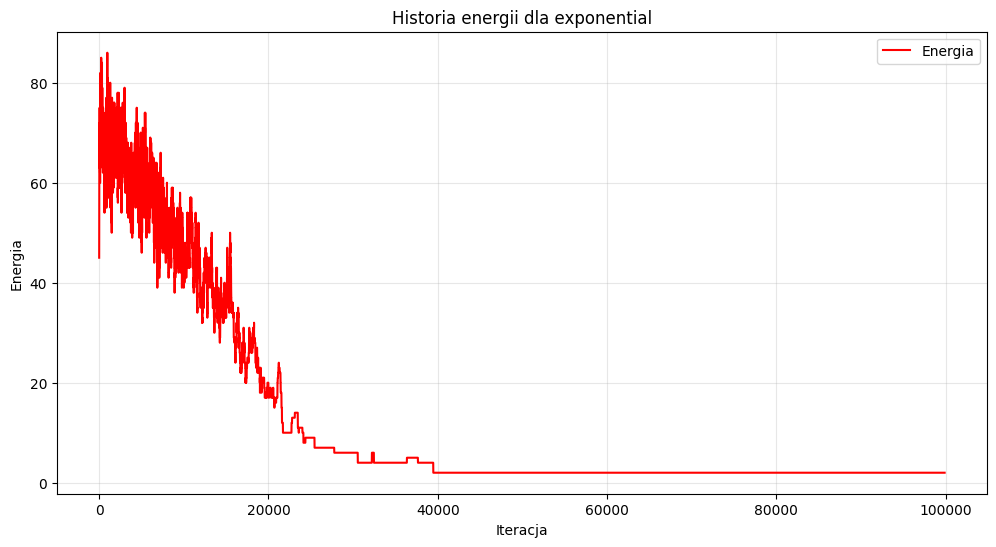

Animacja zapisana jako sudoku_solving_exponential.gif


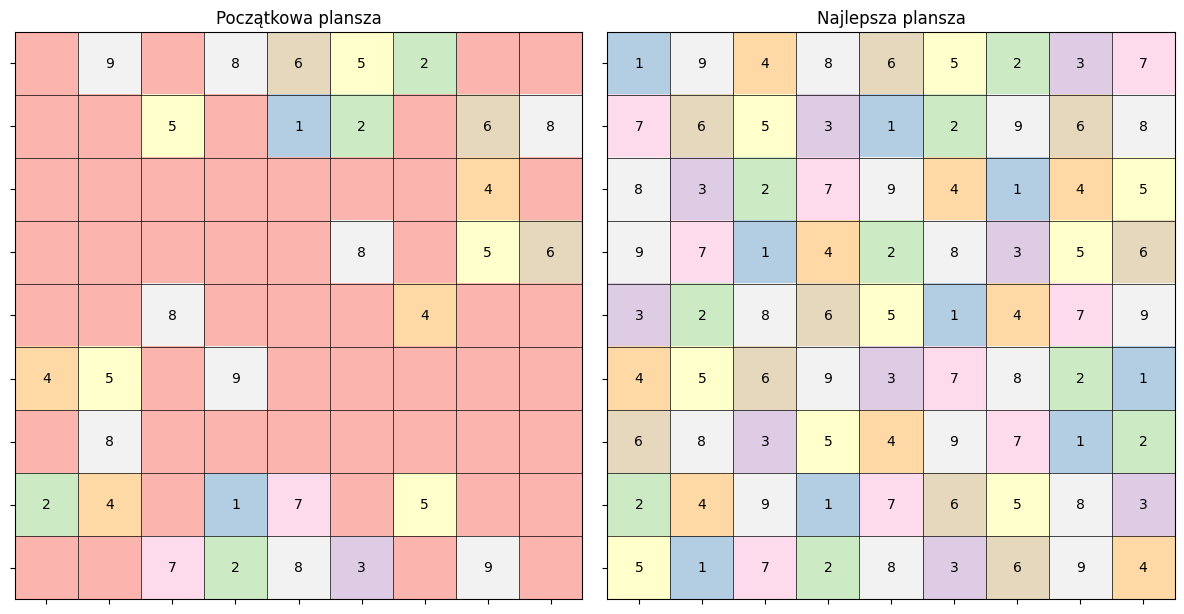

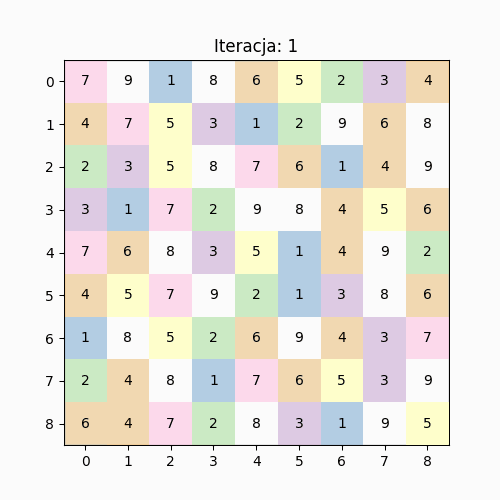

Rozwiazywanie z funkcja chlodzenia geometric z 51 pustymi polami
Iter_count: 69075, best_energy: 4


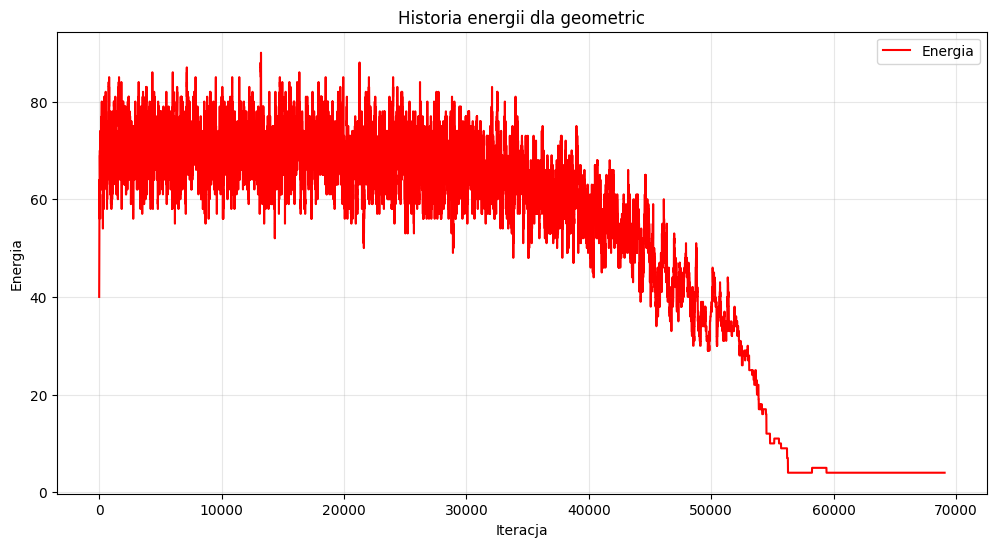

Animacja zapisana jako sudoku_solving_geometric.gif


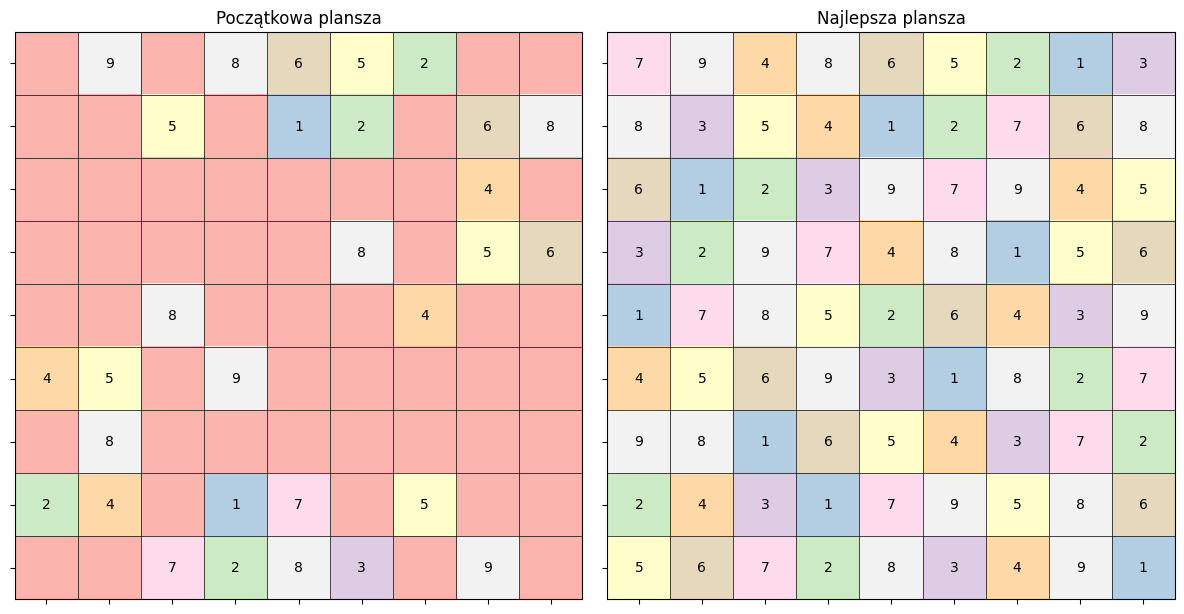

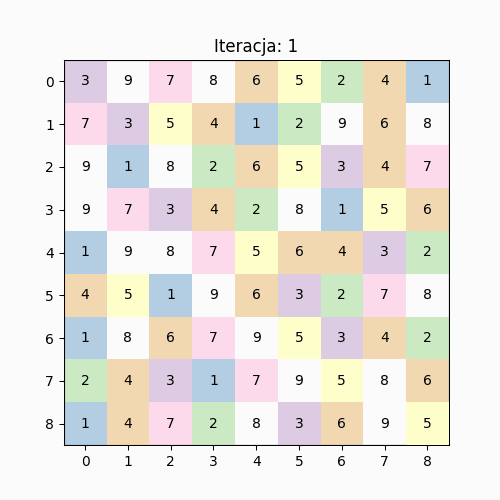

In [405]:
# sudoku, empty_pools = read_sudoku("sudoku.txt", 1)

exponential = lambda x: exponential_cooling(x, 0.0001)
geometric = lambda x: geometric_cooling(x, 0.9999)


for name, func in zip(["exponential", "geometric"], [exponential, geometric]):
    sudoku, empty_pools = read_sudoku_from_json("sudoku.json", 0)
    initial_sudoku = sudoku.copy()
    fill_sudoku(sudoku)


    print(f"Rozwiazywanie z funkcja chlodzenia {name} z {len(empty_pools)} pustymi polami")

    best, best_energy, iter_count, sudoku_history, energy_history = simulated_annealing(sudoku, empty_pools, func)

    print(f"Iter_count: {iter_count}, best_energy: {best_energy}")
    visualize_energy_history(energy_history, f"Historia energii dla {name}", f"energy_history_{name}.png")
    gif = visualize_sudoku_solving(sudoku_history, f"sudoku_solving_{name}.gif")

    display_initial_and_best(initial_sudoku, best)
    display(gif)

Mozemy zaobserowowac, ze pomimo ze algorytm byl "blisko" rozwiazania, to nie poradzil sobie w obu przypadkach. Prawdopodobnie spowodowane jest to tym, ze zeby znalezc ta jedyna poprawna sciezke algorytm powinienby sie cofnac do stanu beznadziejnego i wrecz zaczyac od poczatku do momenu, az trafi ta jedyna poprawna sciezke.

Ponizej zaprezentowana jest moja spektakularna porazka (dla "latwiejszych", jak i trudniejszych plansz)

--------------------------------------------------
Sudoku nr 0 z 51 pustymi polami 
i: 0, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 1


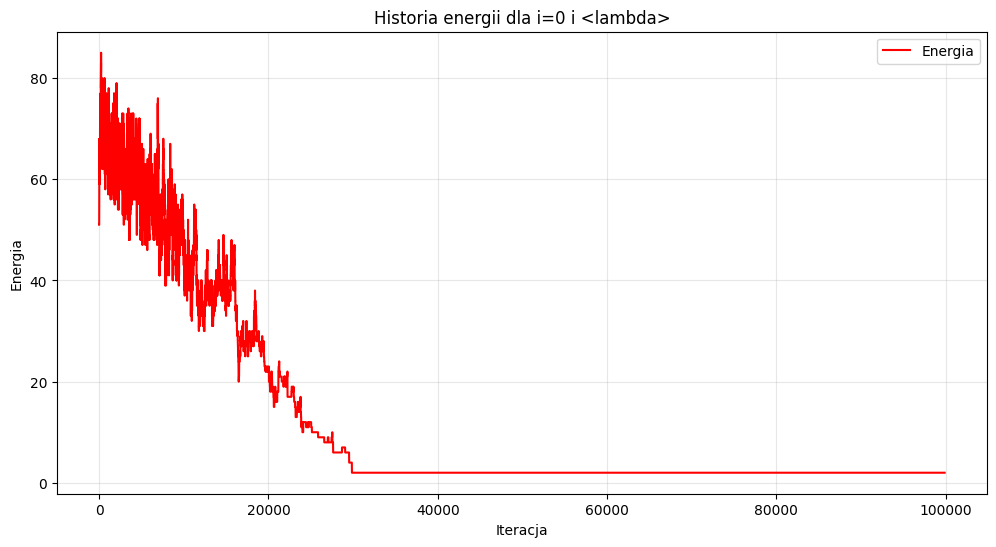

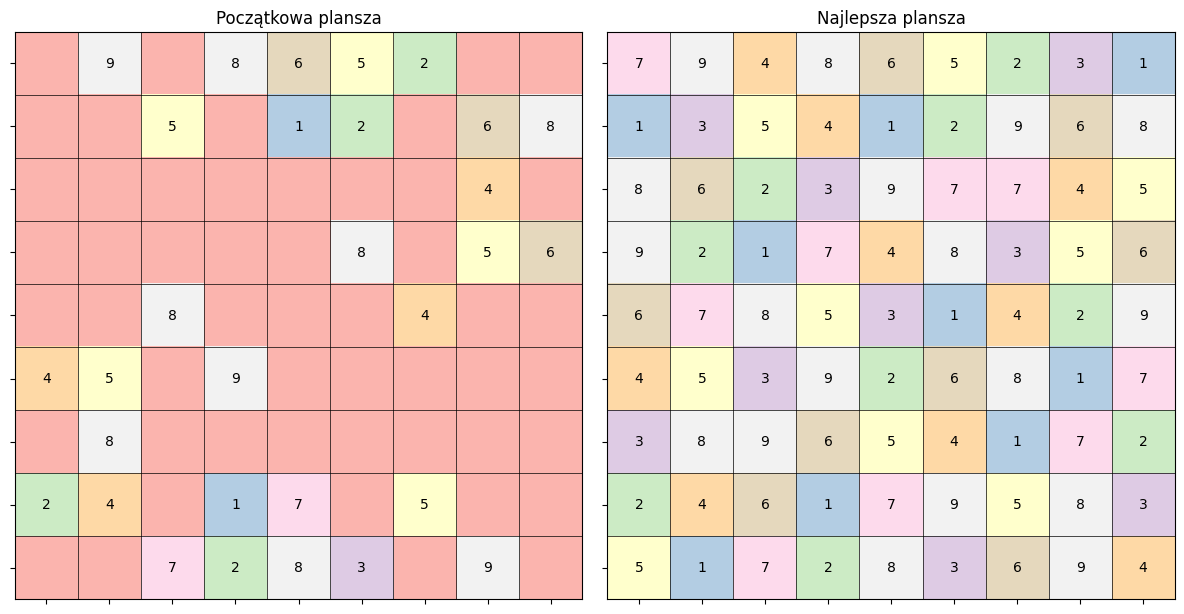

--------------------------------------------------
Sudoku nr 0 z 51 pustymi polami 
i: 0, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


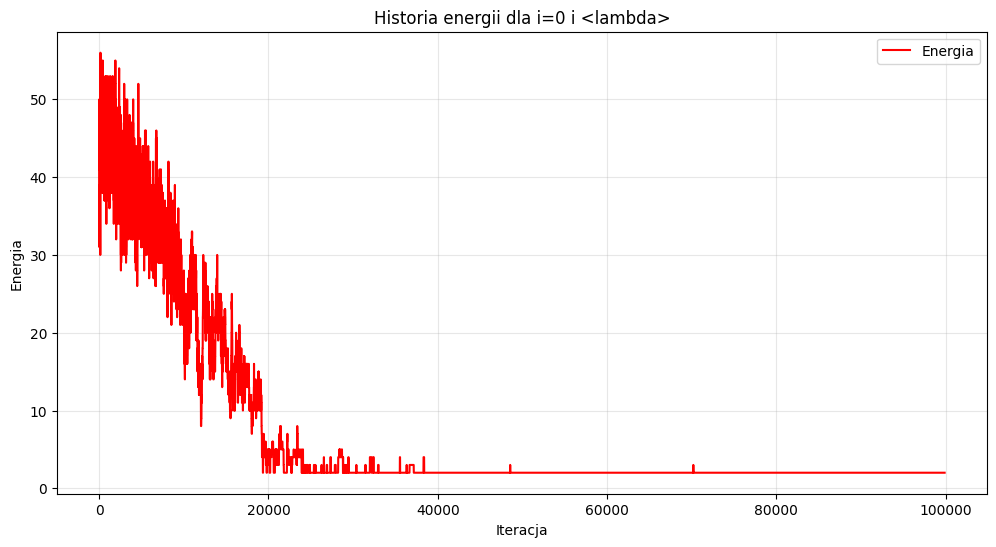

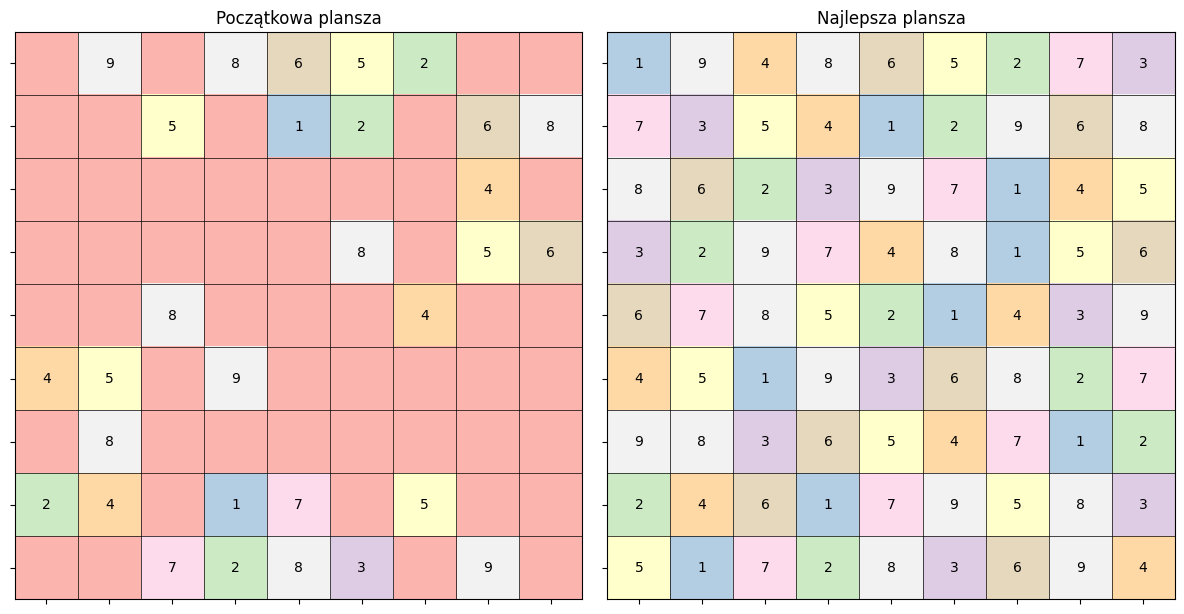

--------------------------------------------------
Sudoku nr 0 z 51 pustymi polami 
i: 0, cooling: <lambda>, iter_count: 69075, best_energy: 3, neigh_type: 1


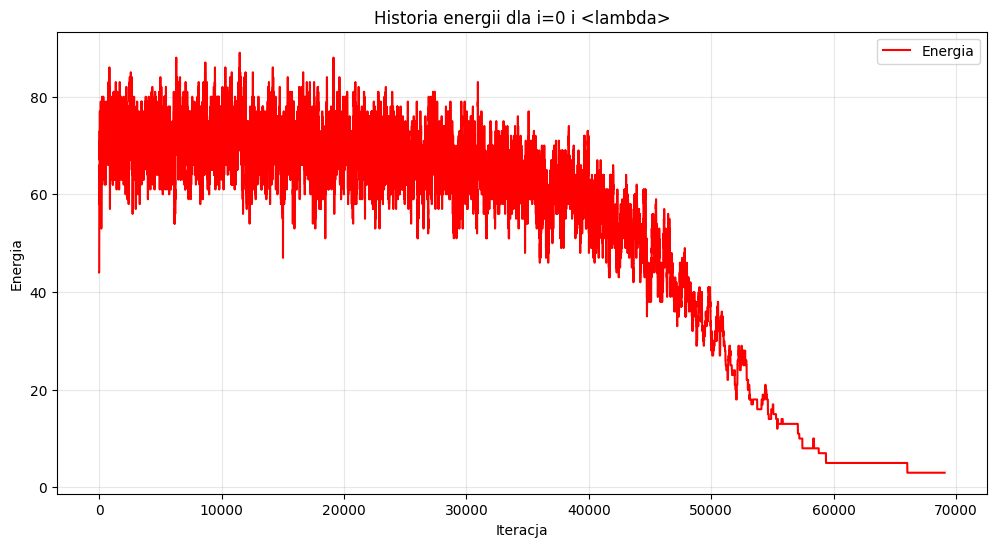

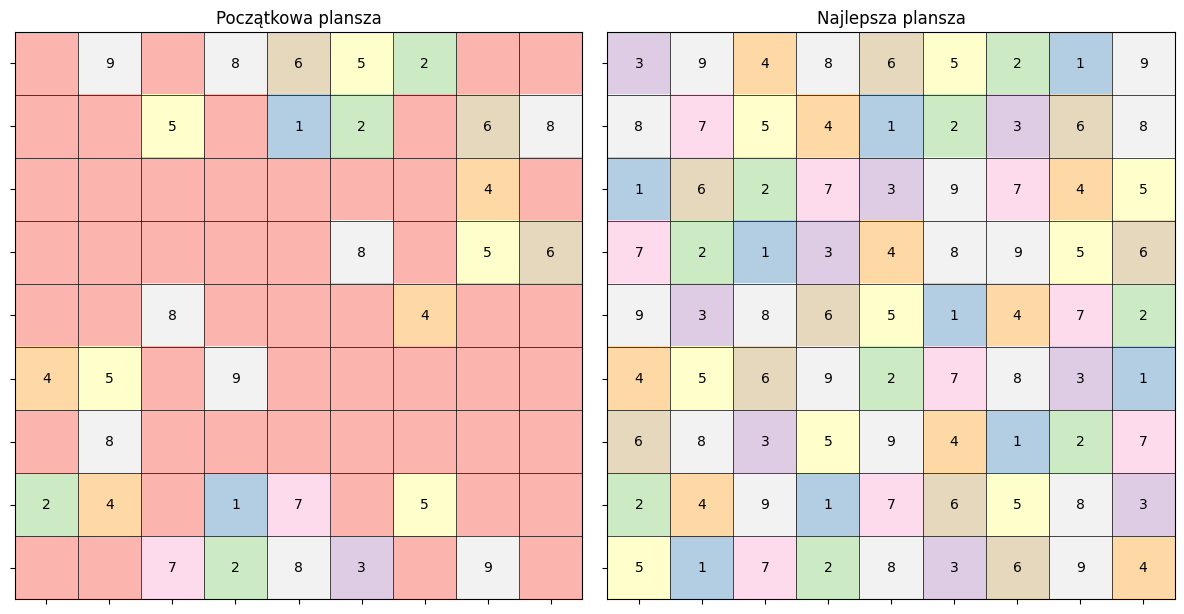

--------------------------------------------------
Sudoku nr 0 z 51 pustymi polami 
i: 0, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 2


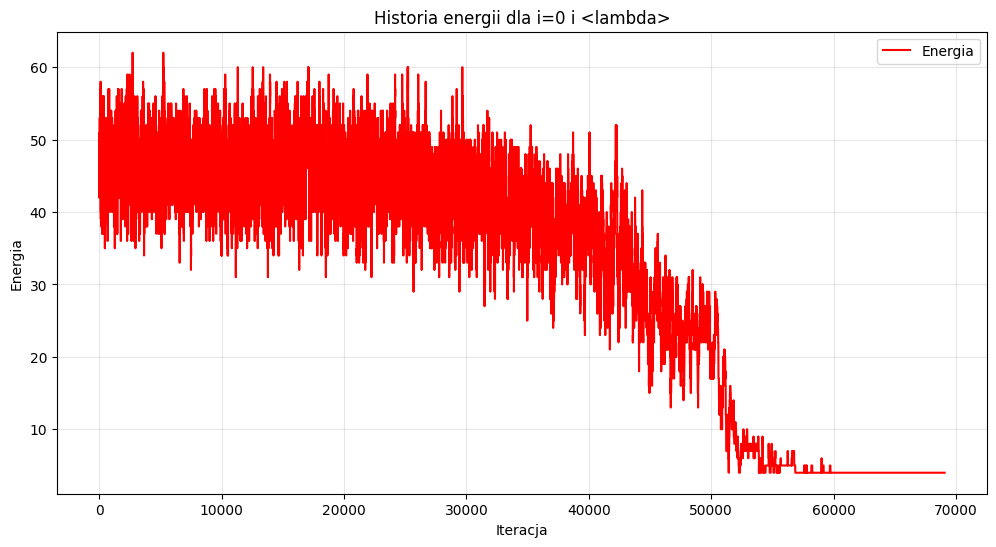

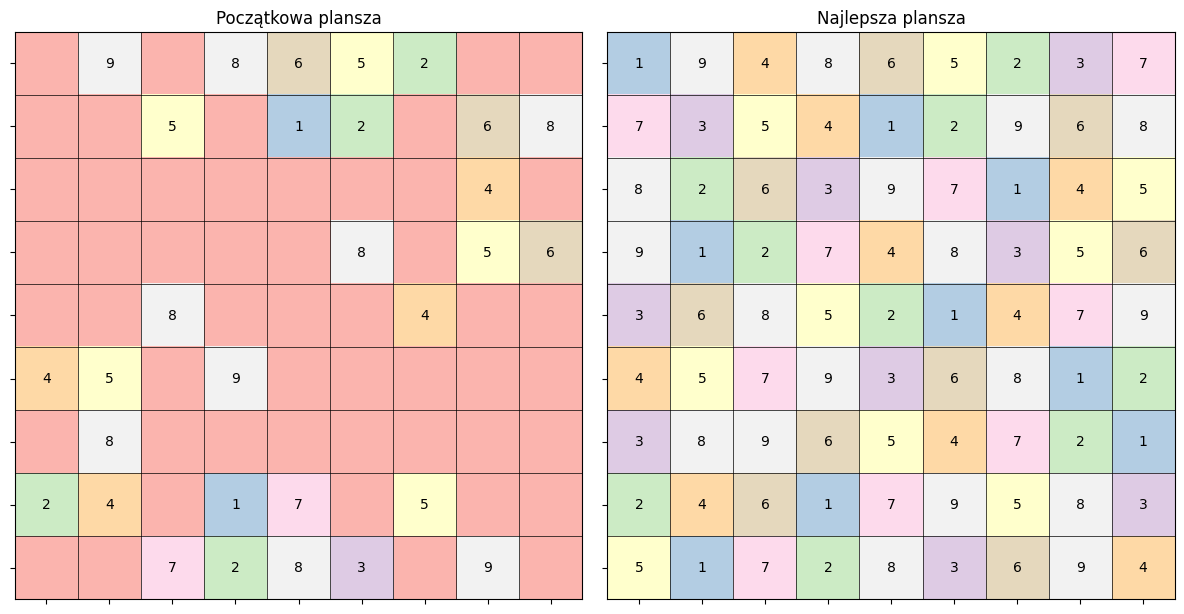

--------------------------------------------------
Sudoku nr 1 z 51 pustymi polami 
i: 1, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 1


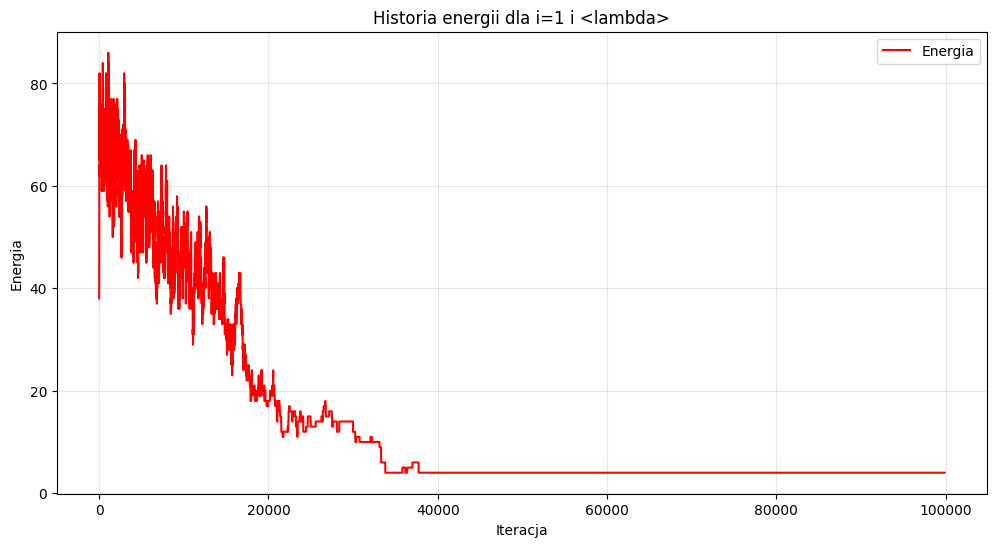

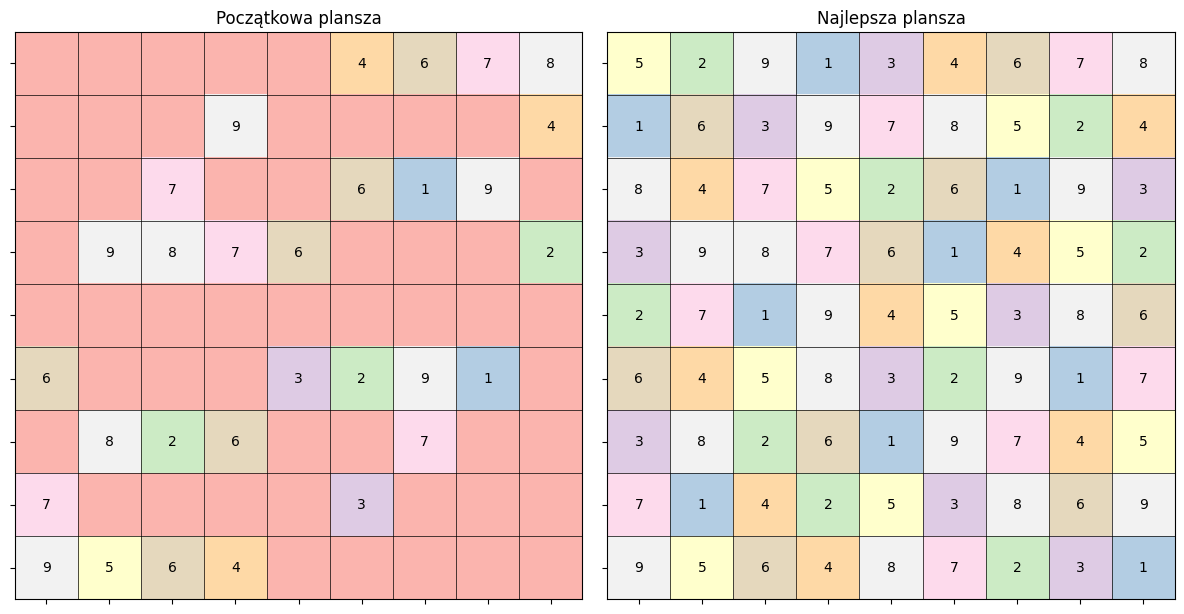

--------------------------------------------------
Sudoku nr 1 z 51 pustymi polami 
i: 1, cooling: <lambda>, iter_count: 18256, best_energy: 0, neigh_type: 2


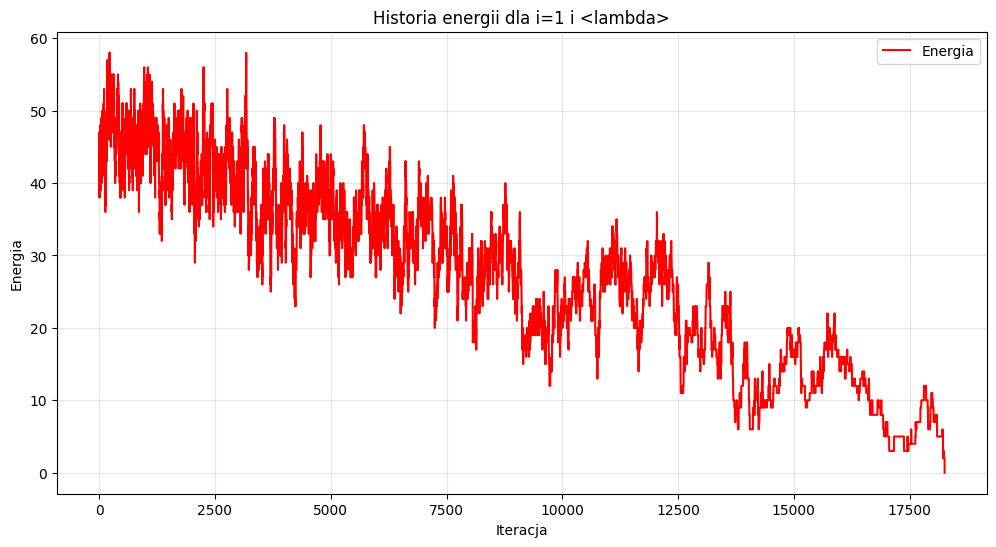

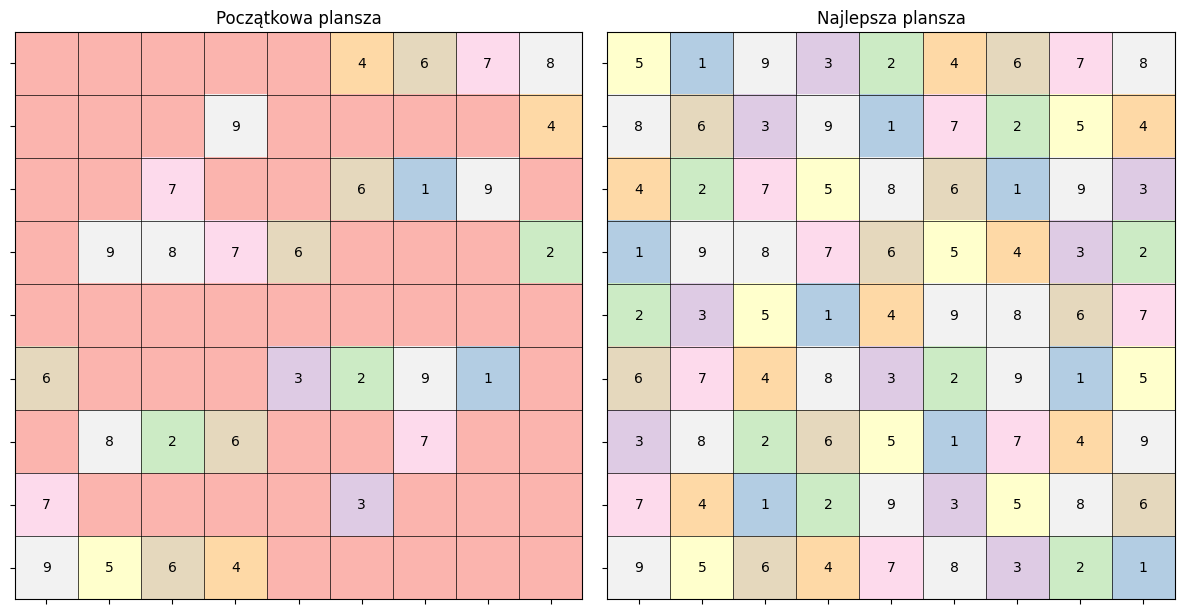

--------------------------------------------------
Sudoku nr 1 z 51 pustymi polami 
i: 1, cooling: <lambda>, iter_count: 69075, best_energy: 3, neigh_type: 1


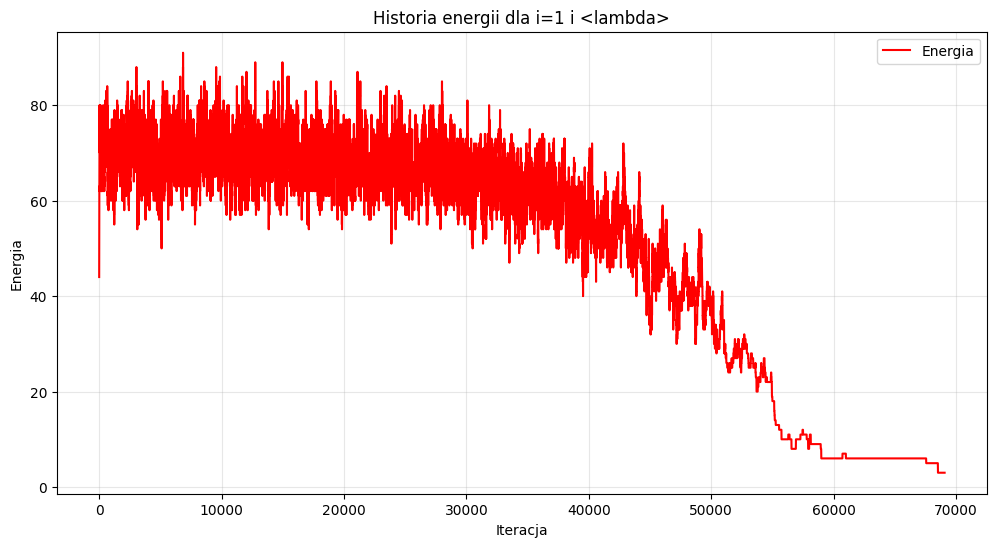

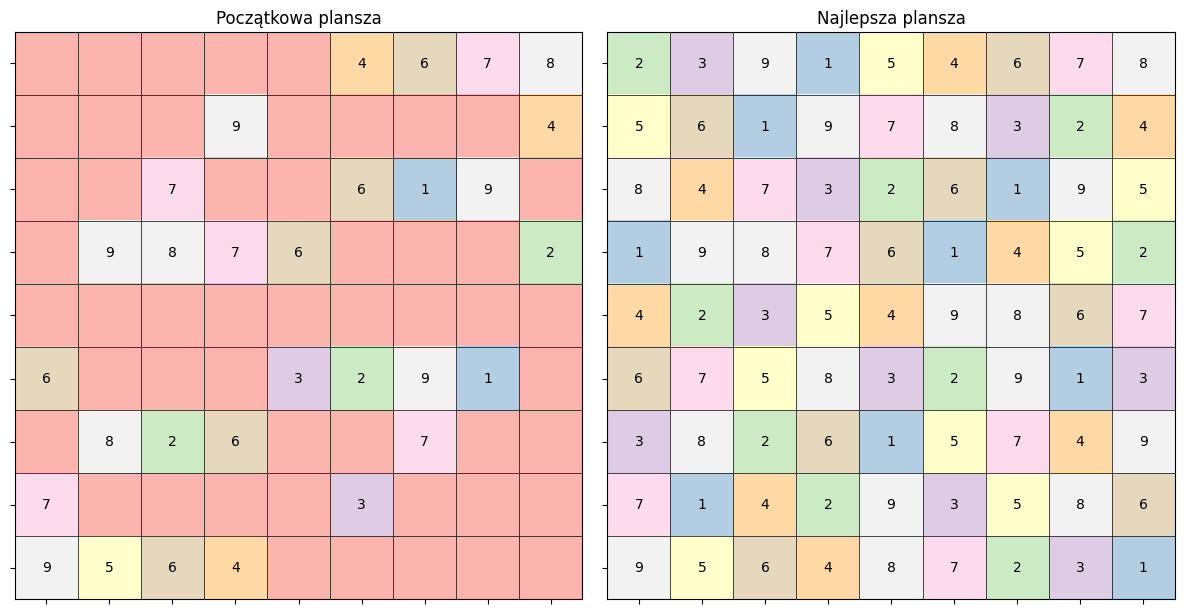

--------------------------------------------------
Sudoku nr 1 z 51 pustymi polami 
i: 1, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 2


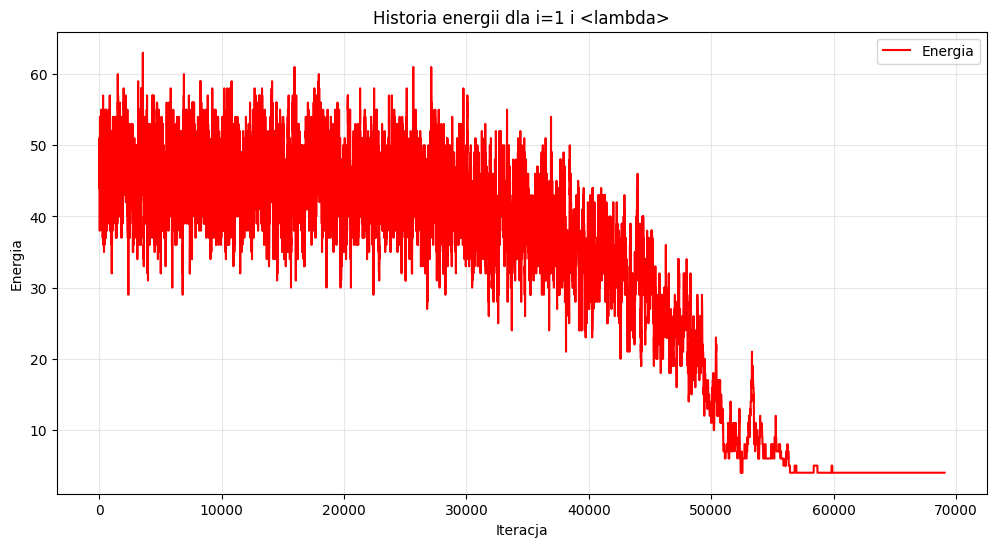

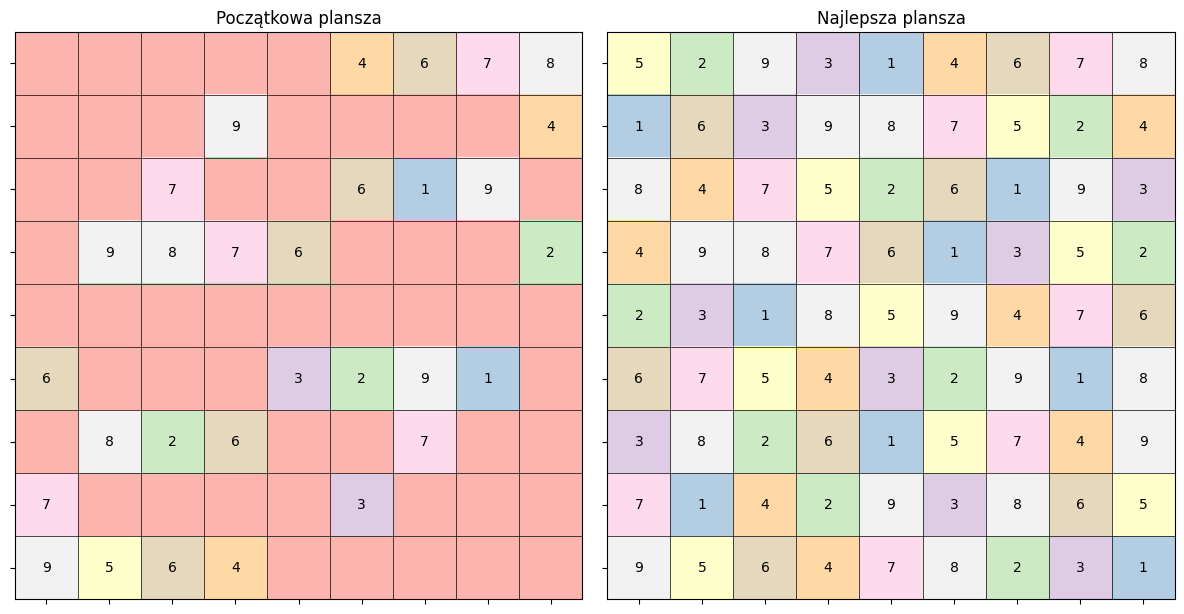

--------------------------------------------------
Sudoku nr 2 z 51 pustymi polami 
i: 2, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 1


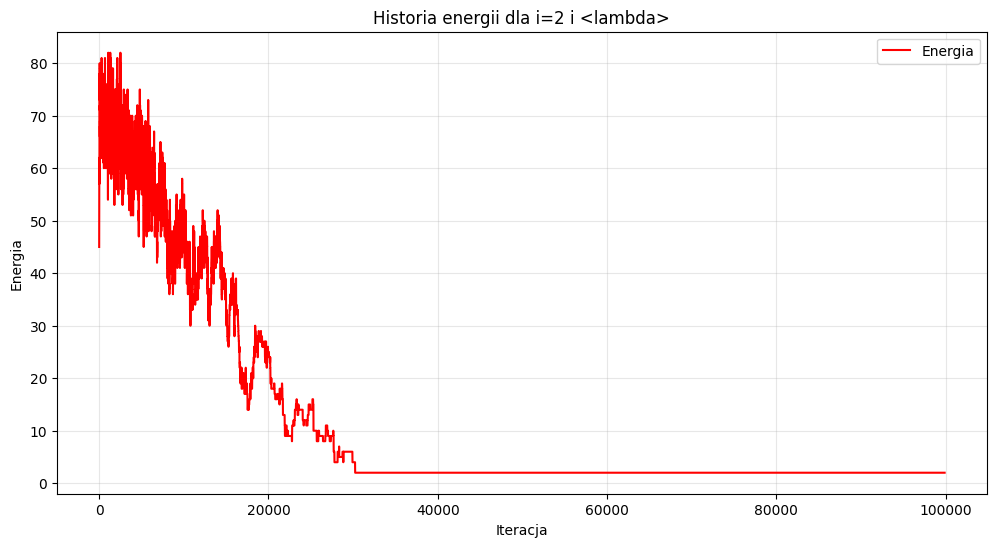

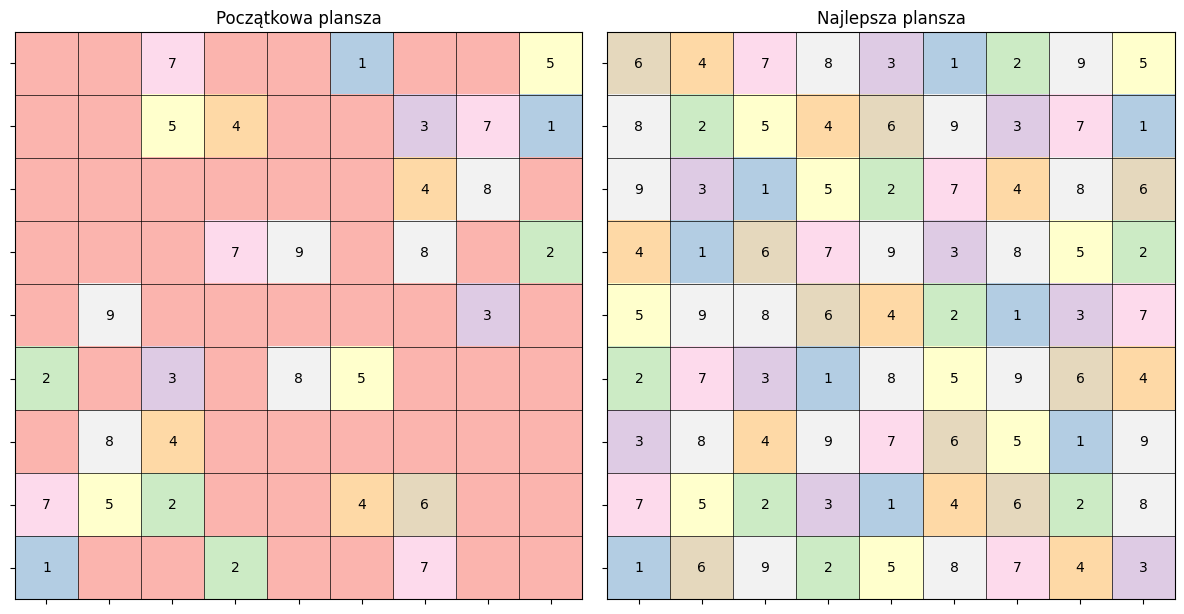

--------------------------------------------------
Sudoku nr 2 z 51 pustymi polami 
i: 2, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


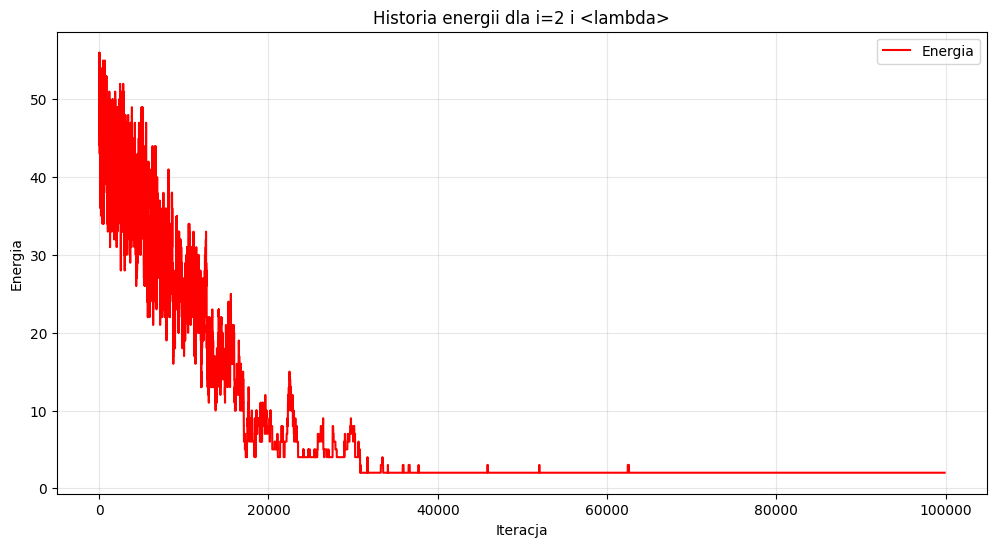

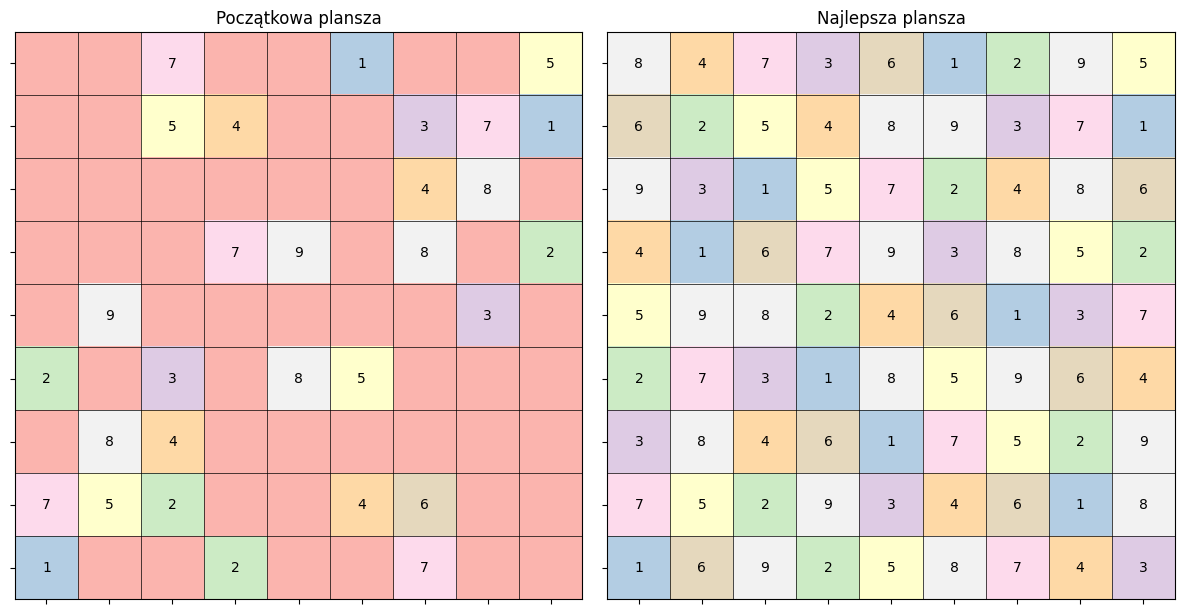

--------------------------------------------------
Sudoku nr 2 z 51 pustymi polami 
i: 2, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 1


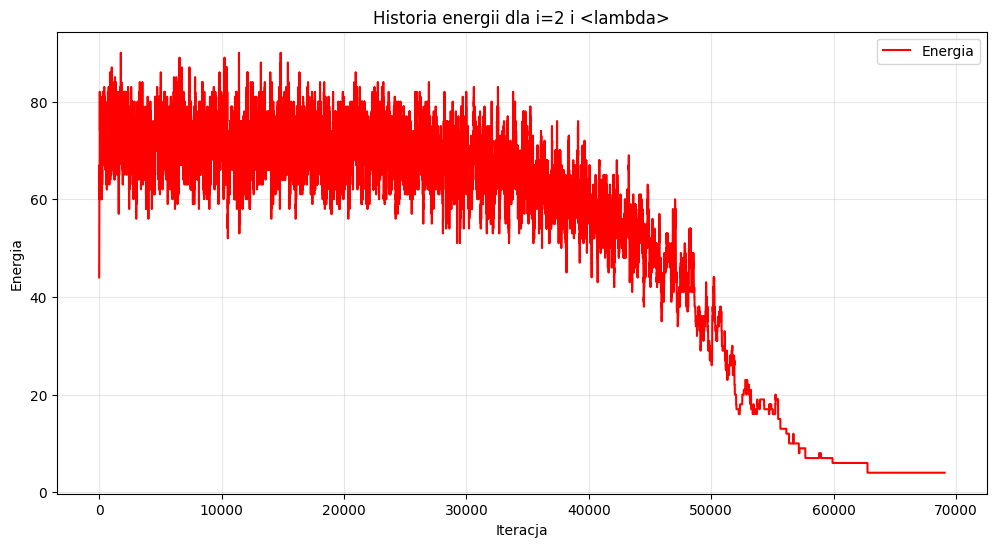

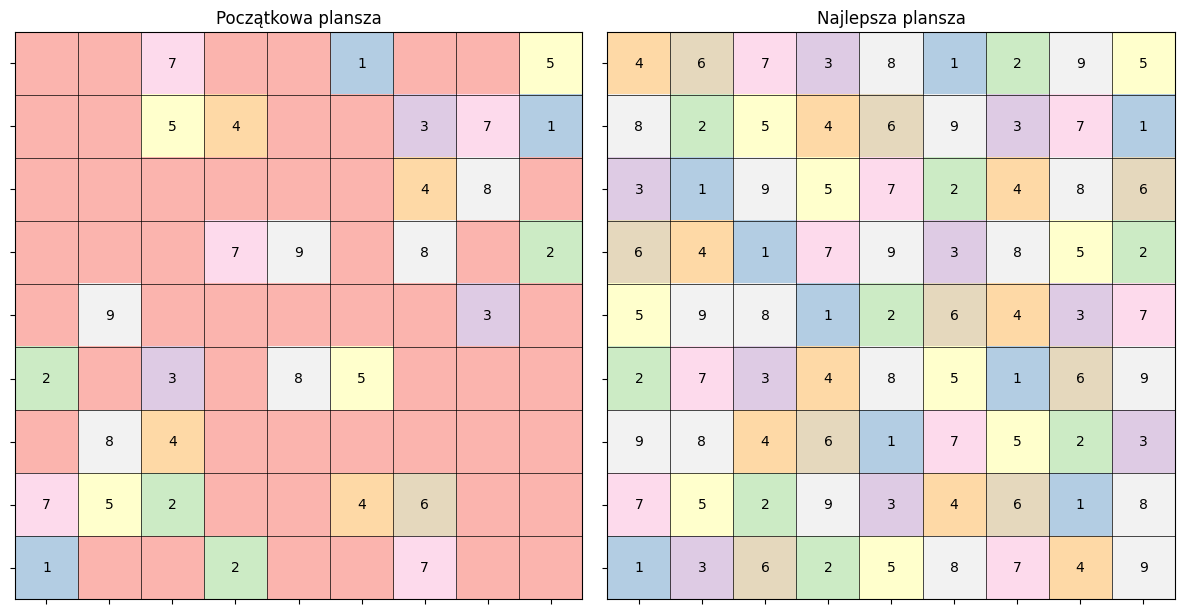

--------------------------------------------------
Sudoku nr 2 z 51 pustymi polami 
i: 2, cooling: <lambda>, iter_count: 69075, best_energy: 2, neigh_type: 2


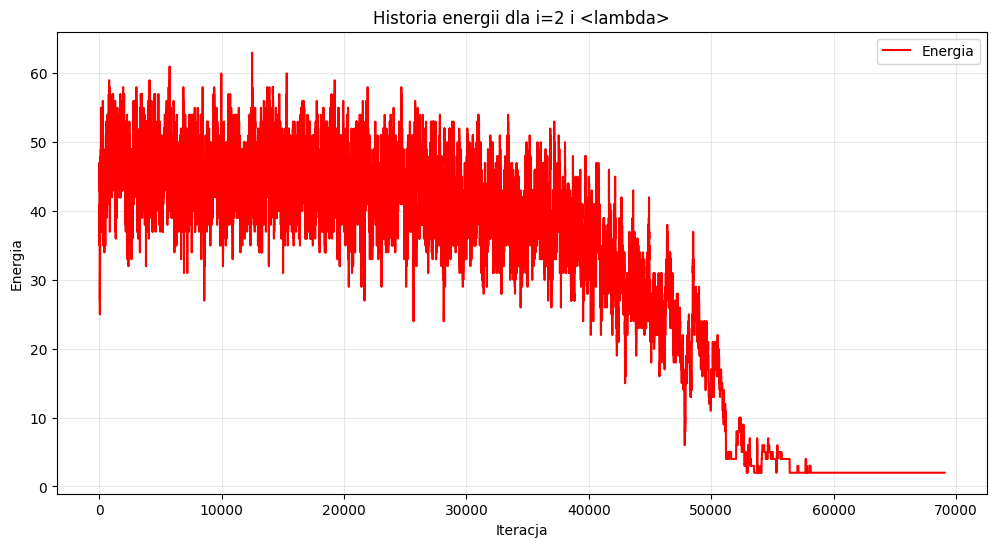

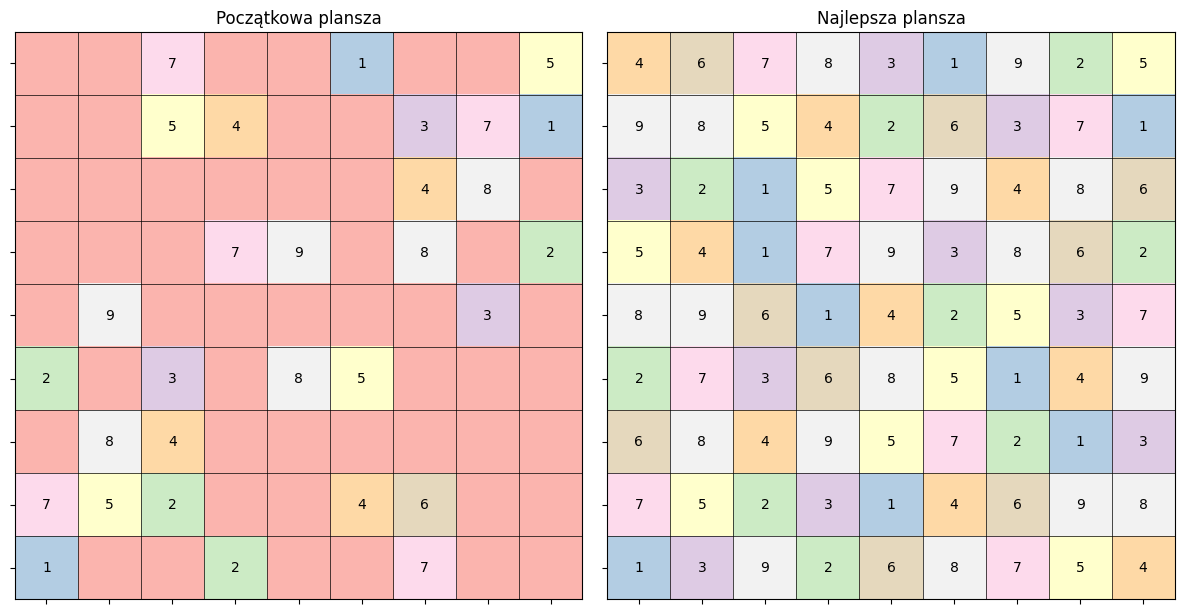

--------------------------------------------------
Sudoku nr 3 z 51 pustymi polami 
i: 3, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 1


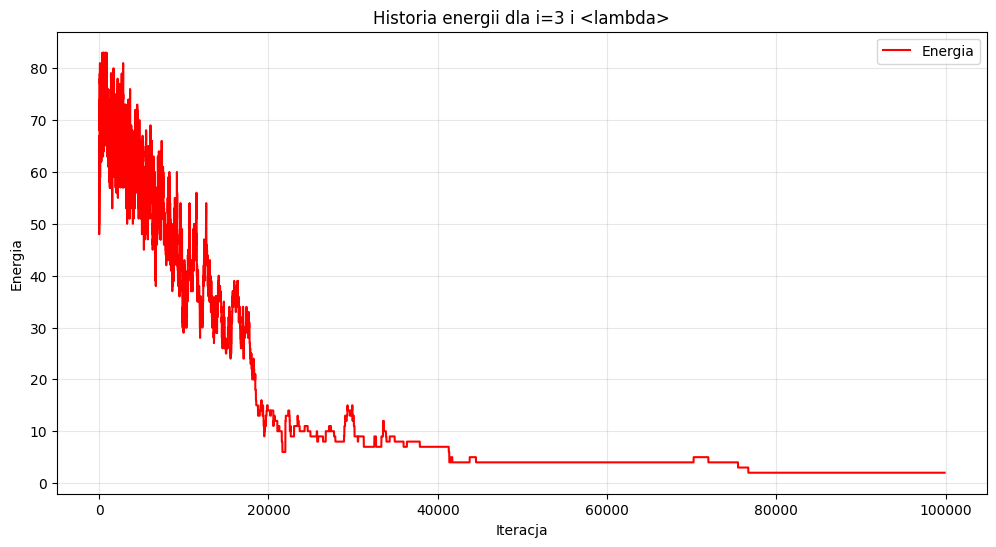

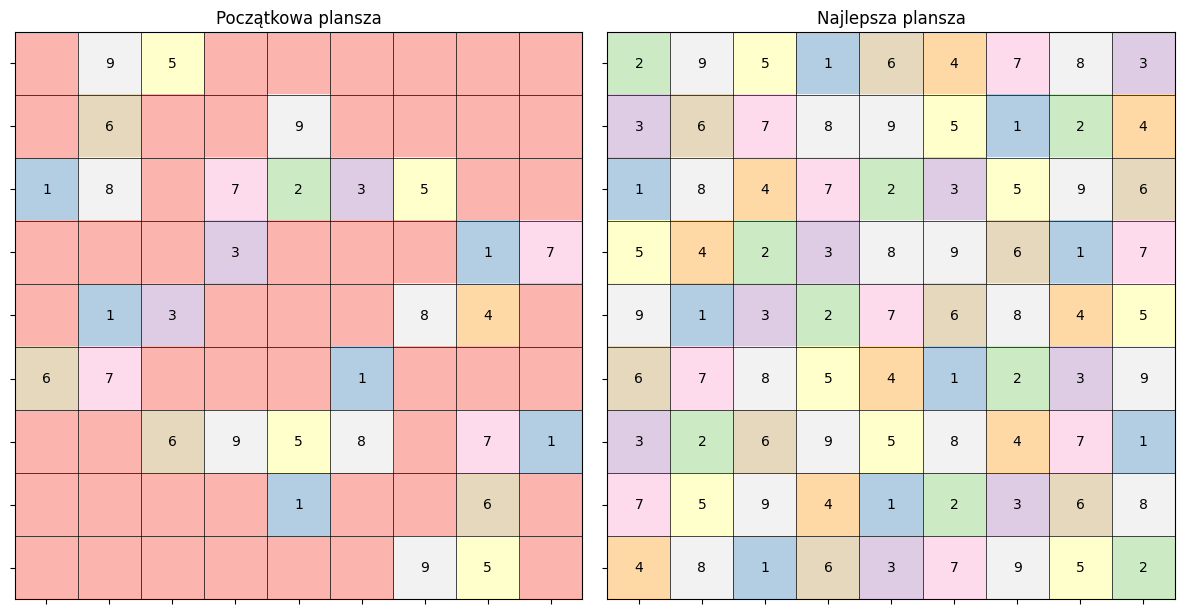

--------------------------------------------------
Sudoku nr 3 z 51 pustymi polami 
i: 3, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


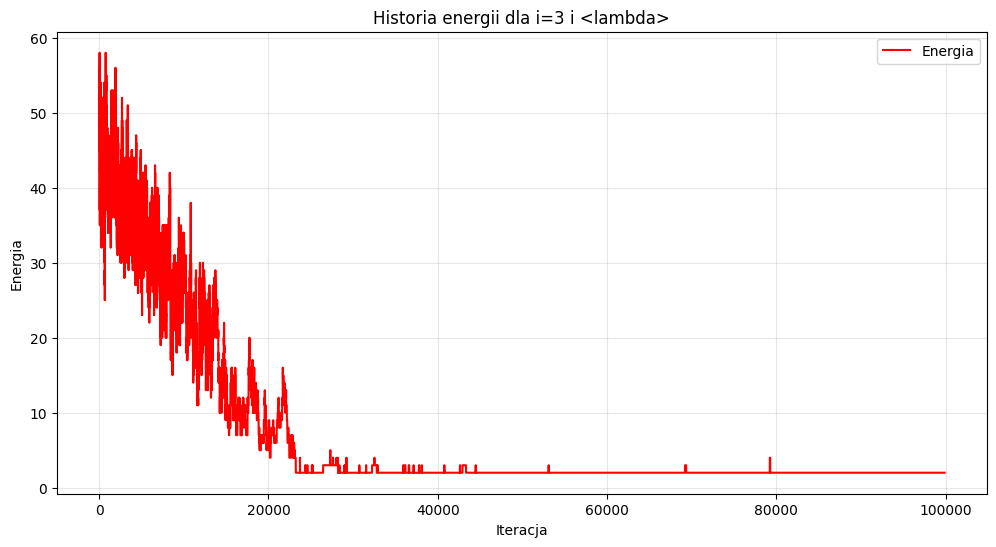

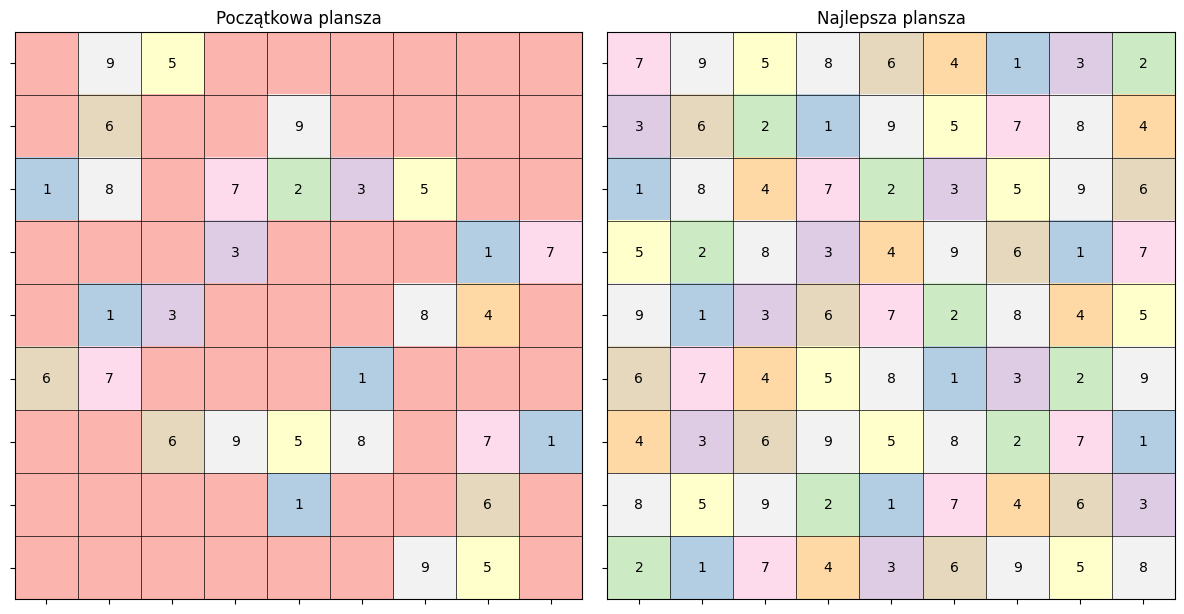

--------------------------------------------------
Sudoku nr 3 z 51 pustymi polami 
i: 3, cooling: <lambda>, iter_count: 69075, best_energy: 2, neigh_type: 1


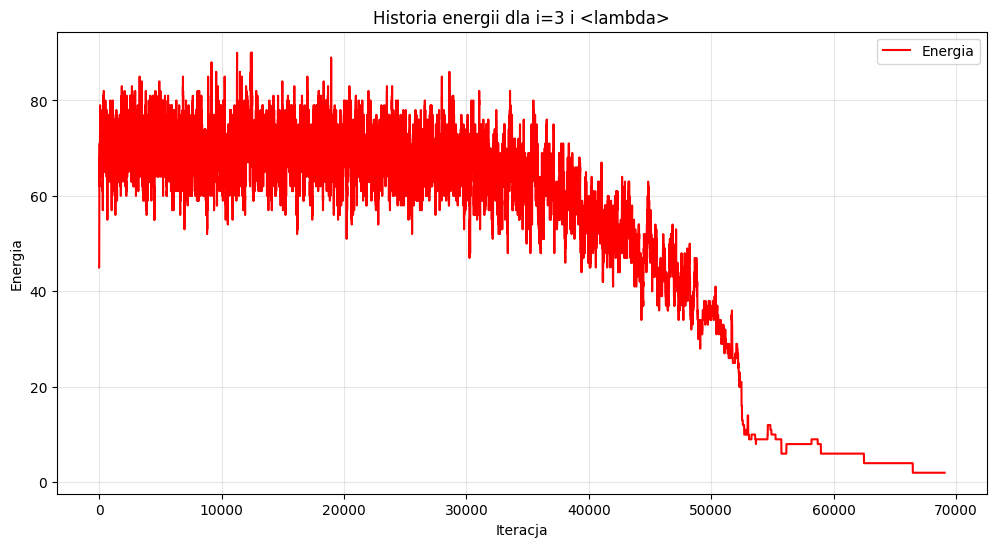

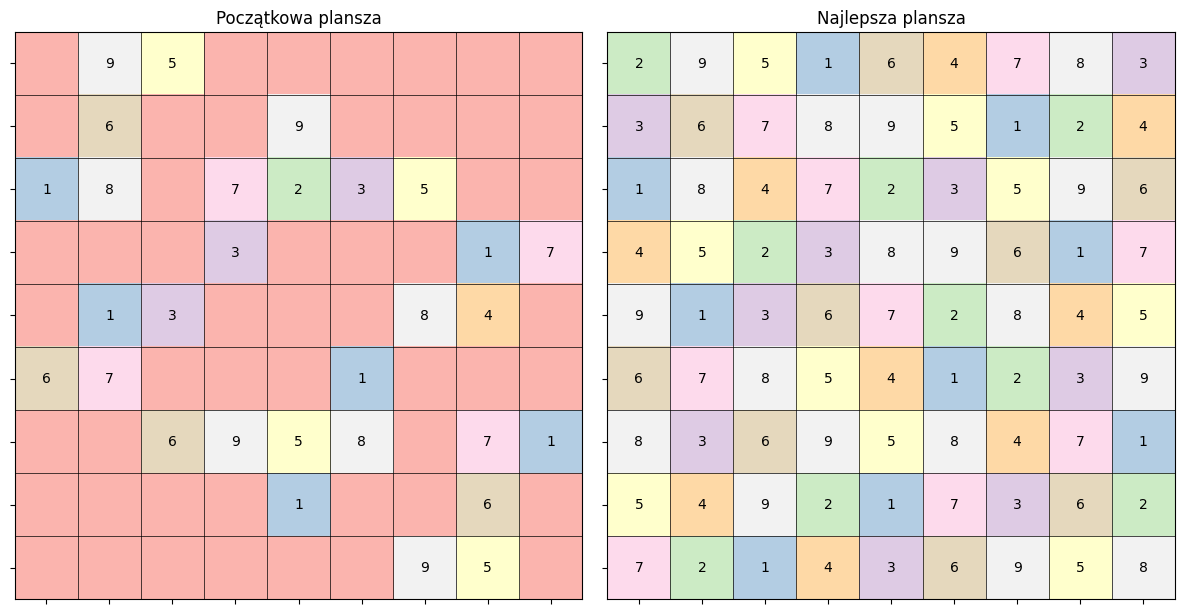

--------------------------------------------------
Sudoku nr 3 z 51 pustymi polami 
i: 3, cooling: <lambda>, iter_count: 69075, best_energy: 2, neigh_type: 2


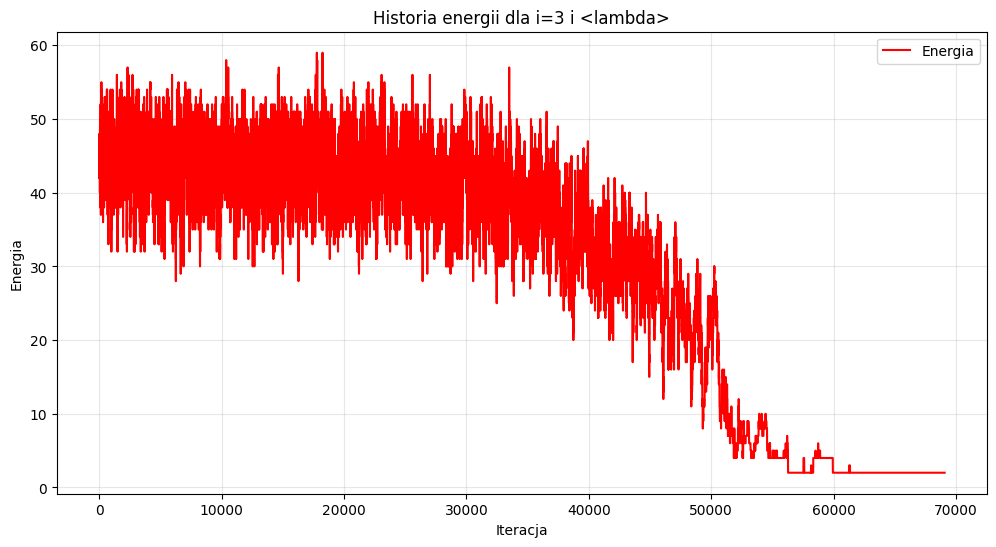

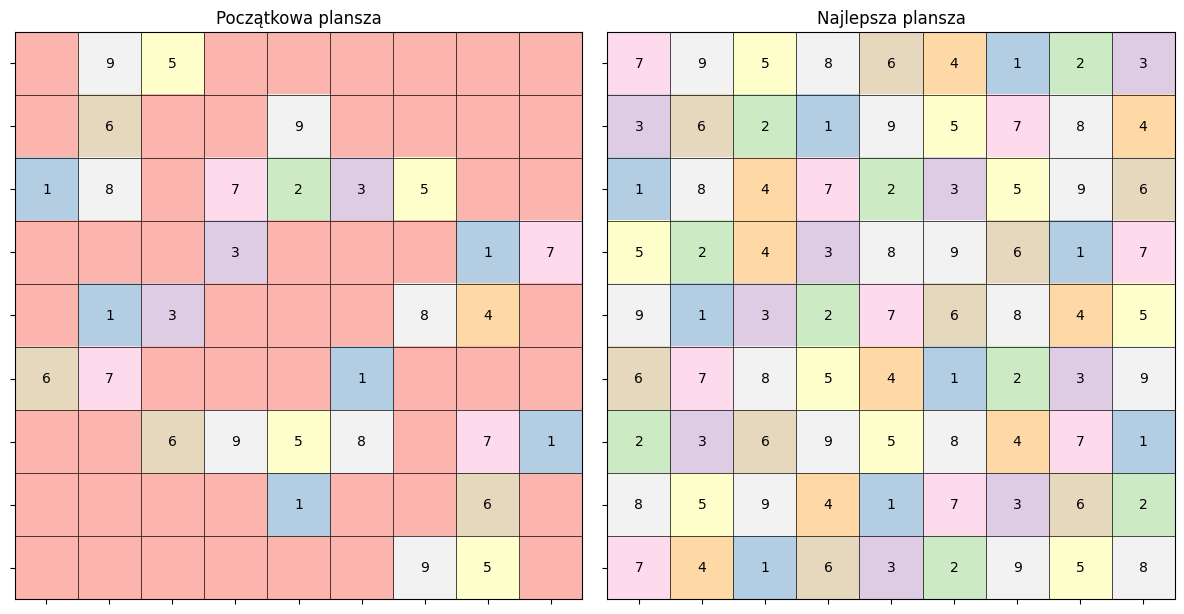

--------------------------------------------------
Sudoku nr 4 z 51 pustymi polami 
i: 4, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 1


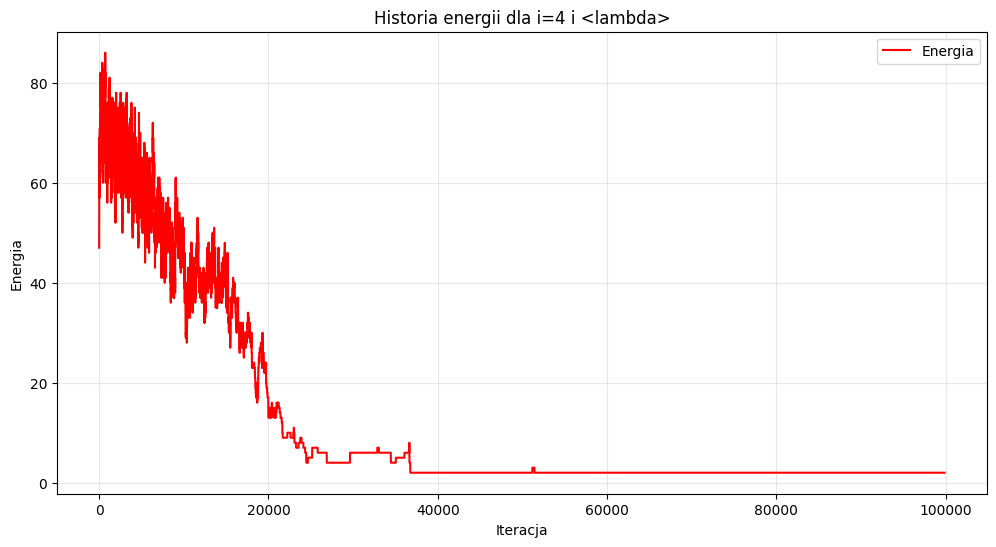

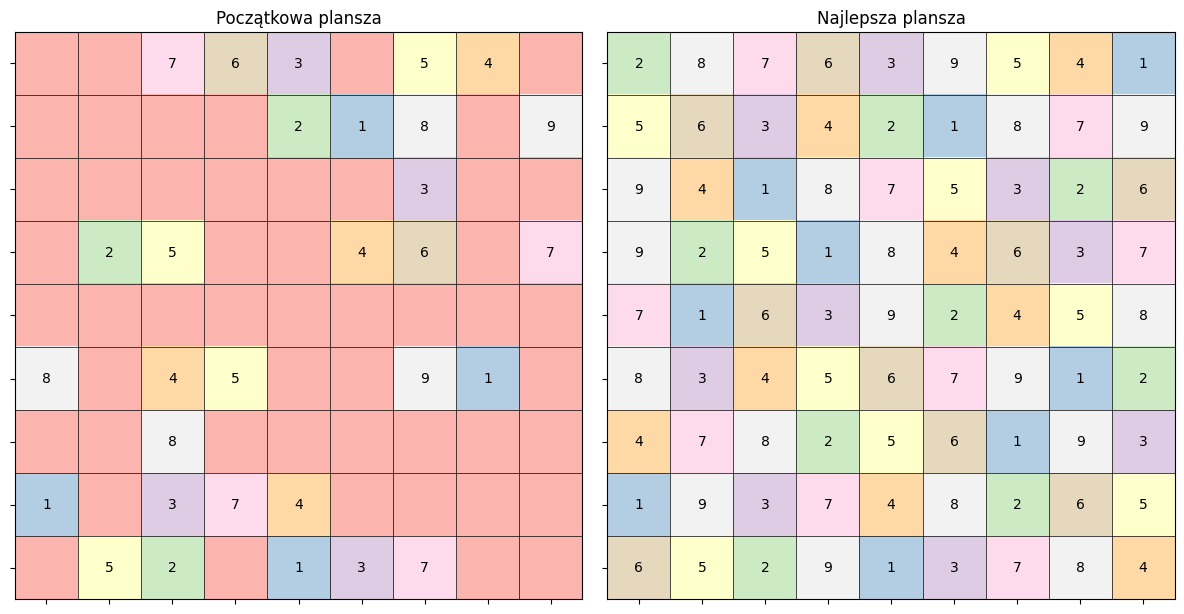

--------------------------------------------------
Sudoku nr 4 z 51 pustymi polami 
i: 4, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


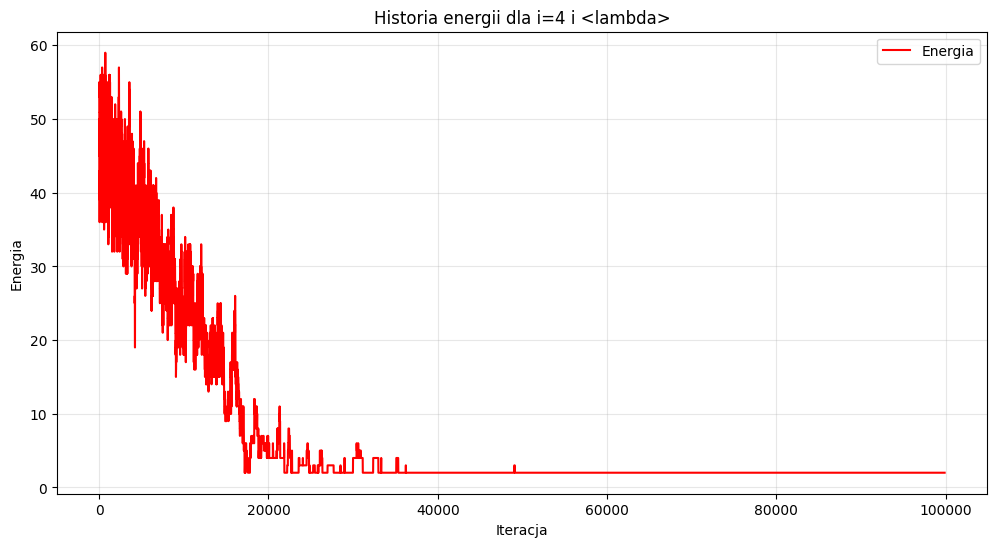

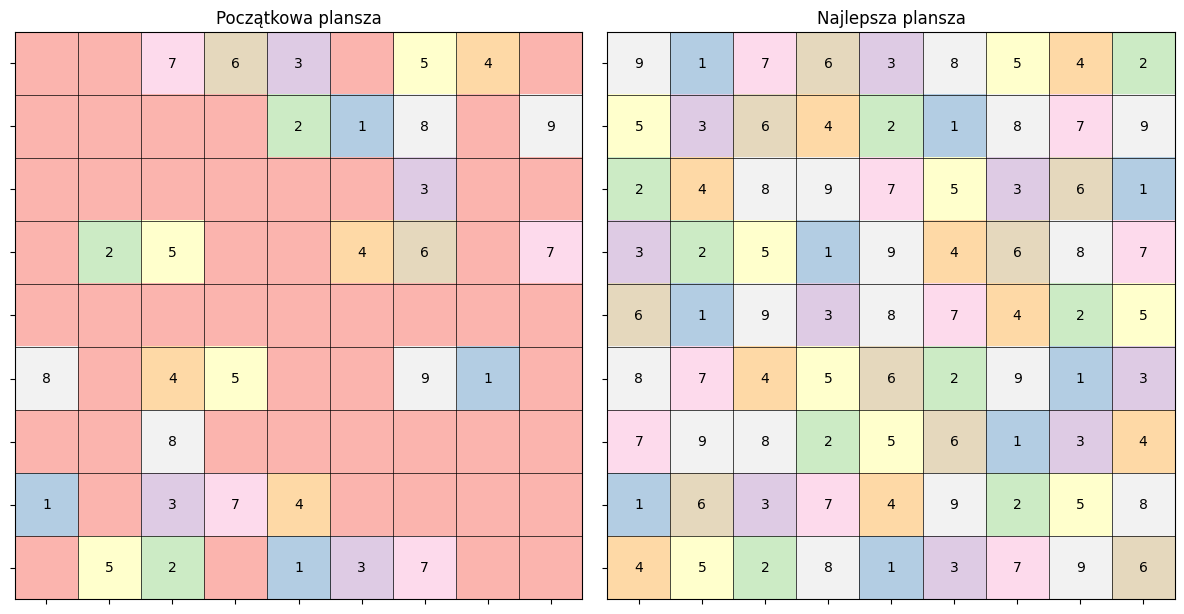

--------------------------------------------------
Sudoku nr 4 z 51 pustymi polami 
i: 4, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 1


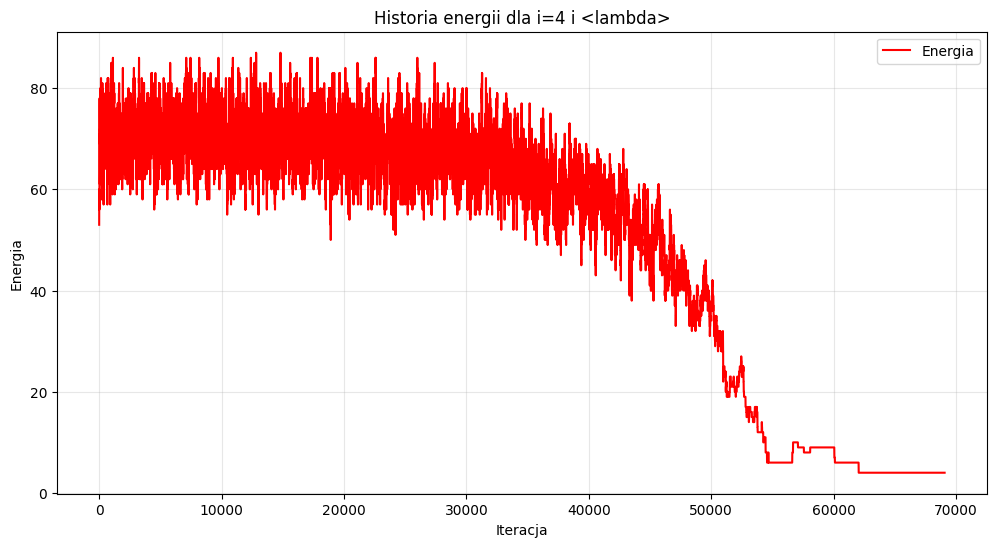

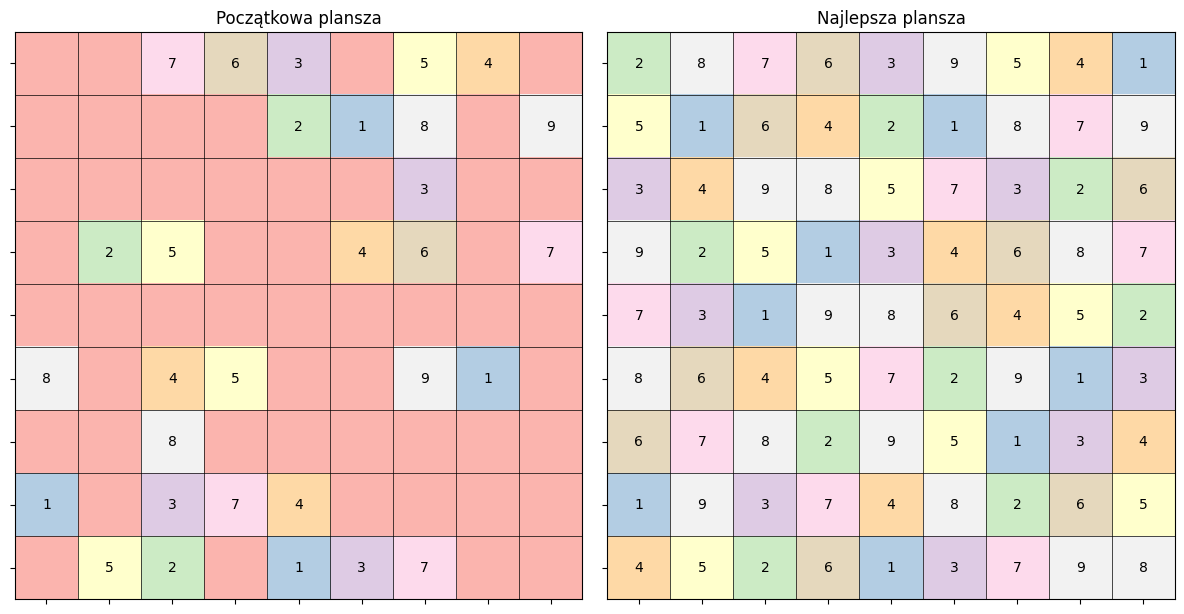

--------------------------------------------------
Sudoku nr 4 z 51 pustymi polami 
i: 4, cooling: <lambda>, iter_count: 69075, best_energy: 2, neigh_type: 2


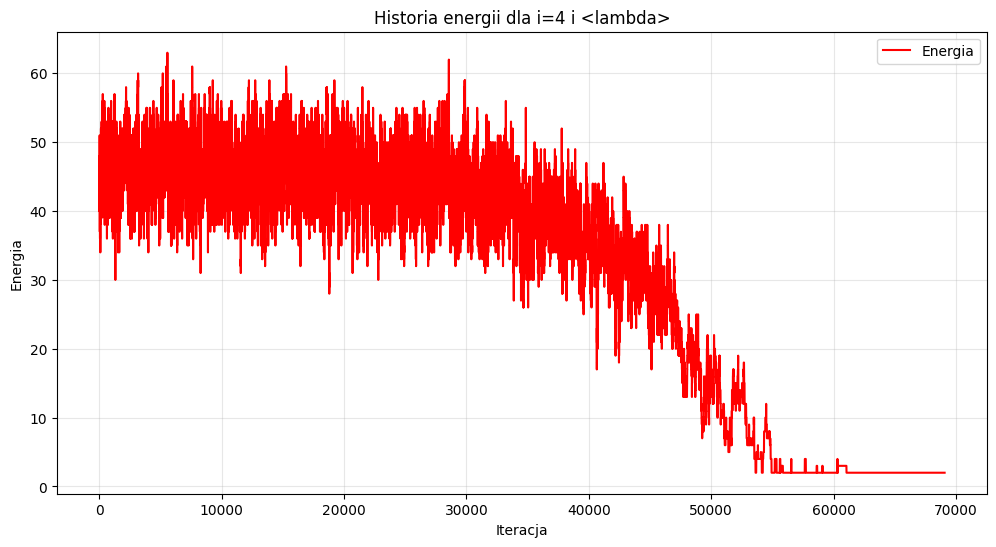

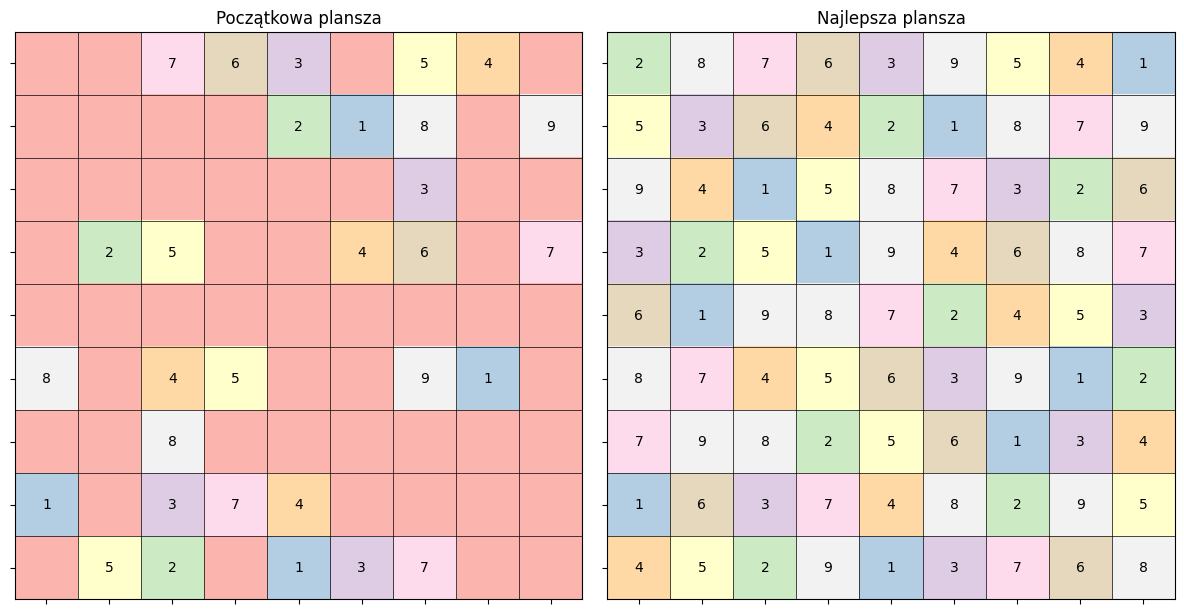

--------------------------------------------------
Sudoku nr 5 z 59 pustymi polami 
i: 5, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 1


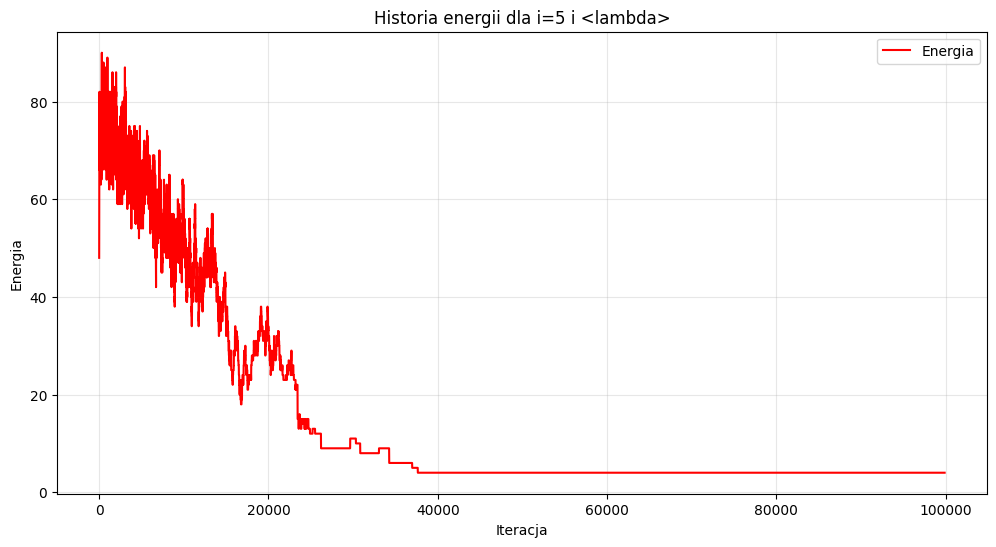

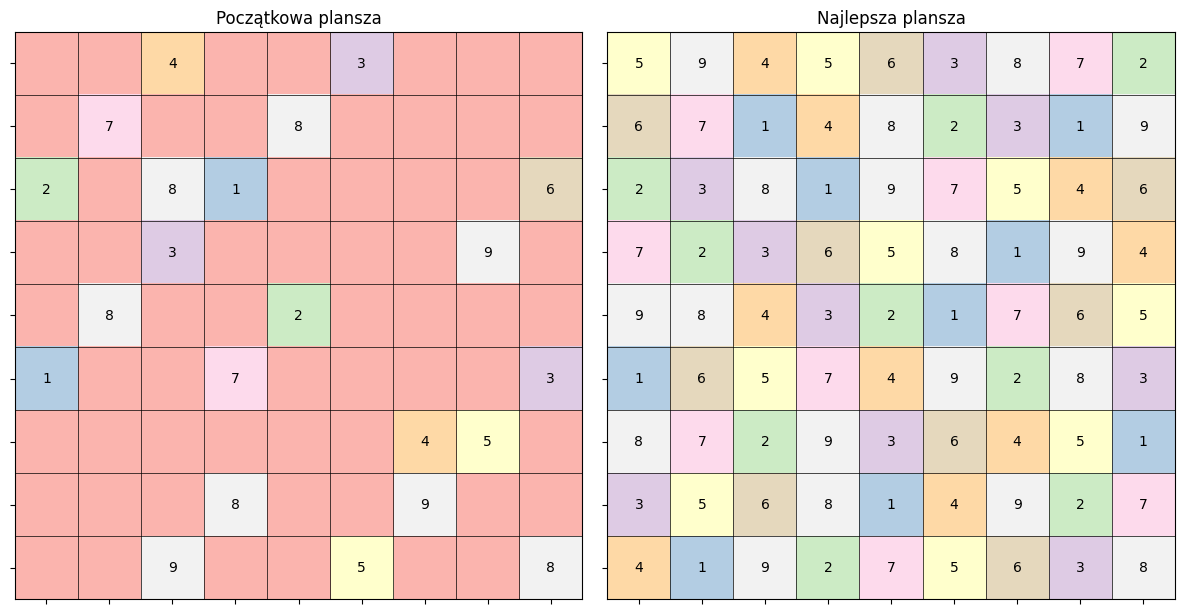

--------------------------------------------------
Sudoku nr 5 z 59 pustymi polami 
i: 5, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


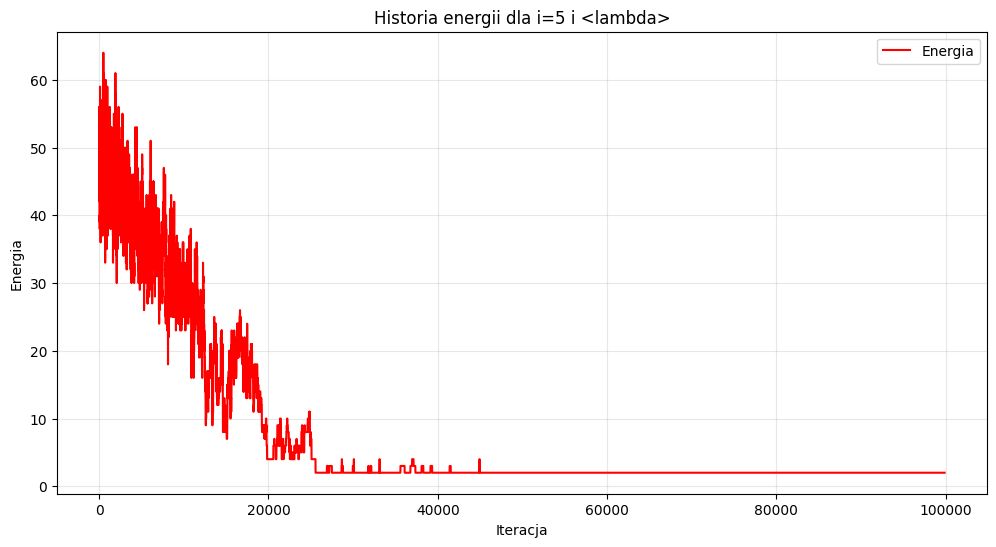

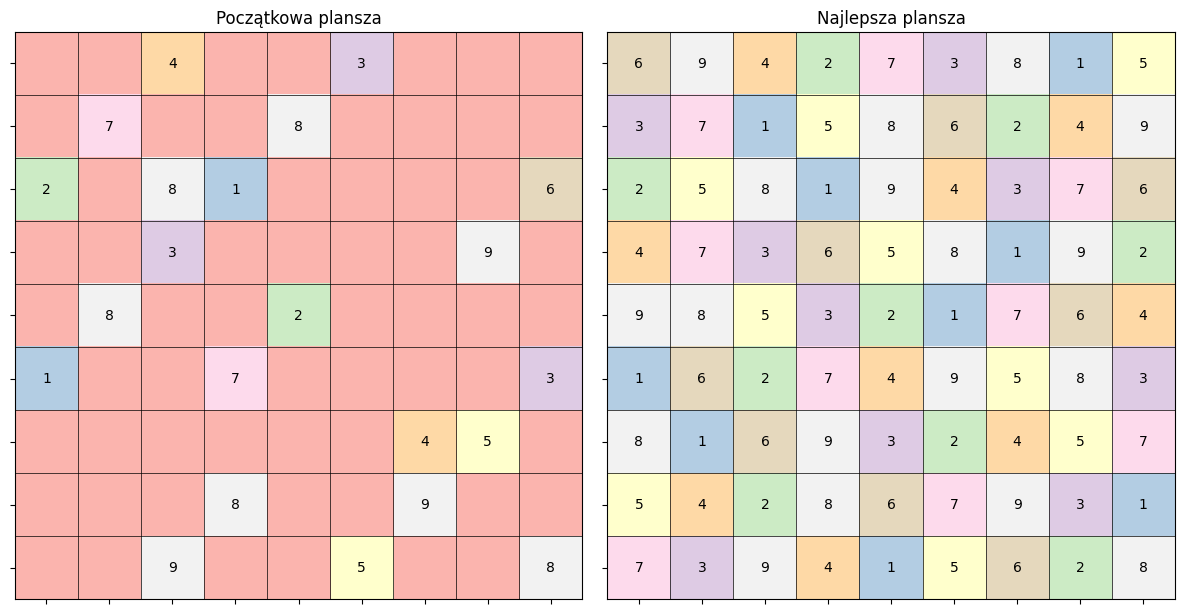

--------------------------------------------------
Sudoku nr 5 z 59 pustymi polami 
i: 5, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 1


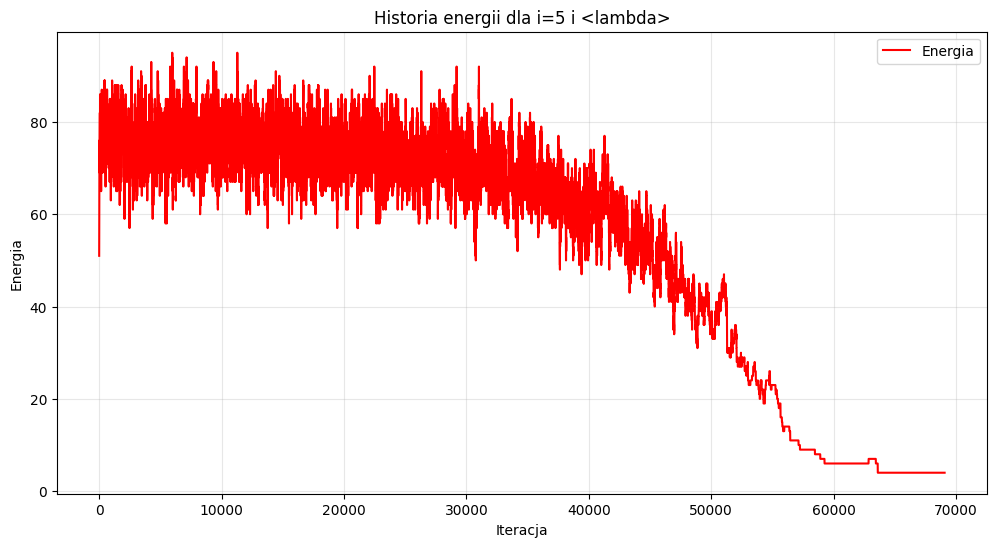

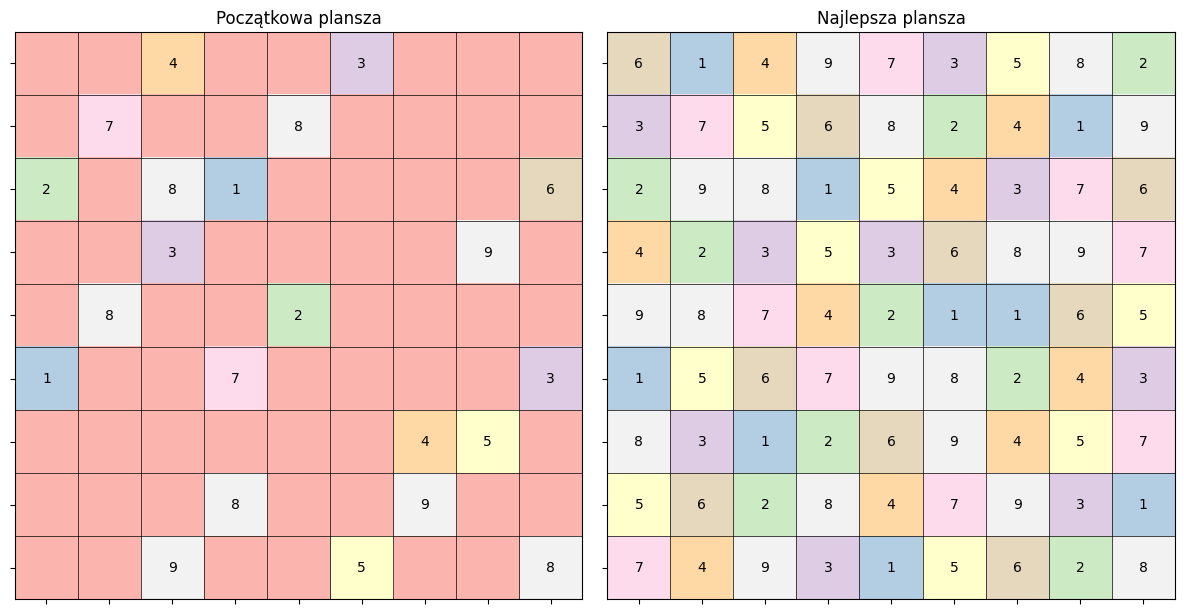

--------------------------------------------------
Sudoku nr 5 z 59 pustymi polami 
i: 5, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 2


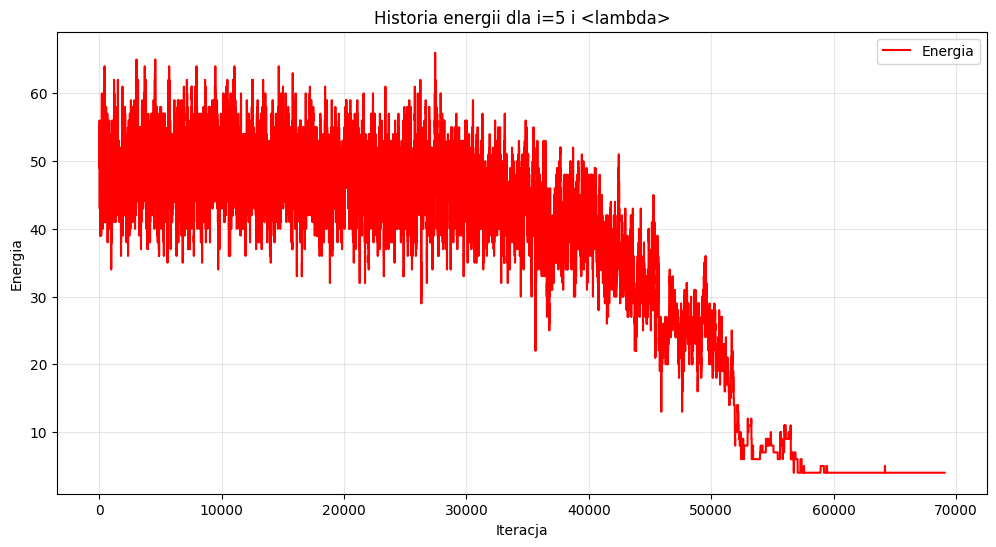

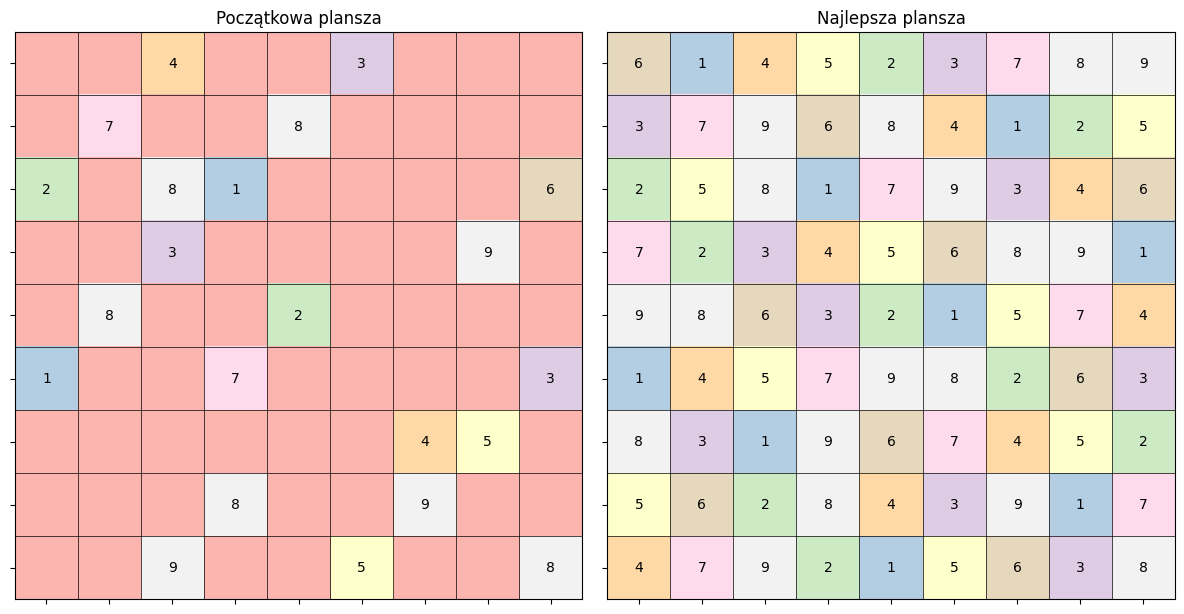

--------------------------------------------------
Sudoku nr 6 z 59 pustymi polami 
i: 6, cooling: <lambda>, iter_count: 99897, best_energy: 6, neigh_type: 1


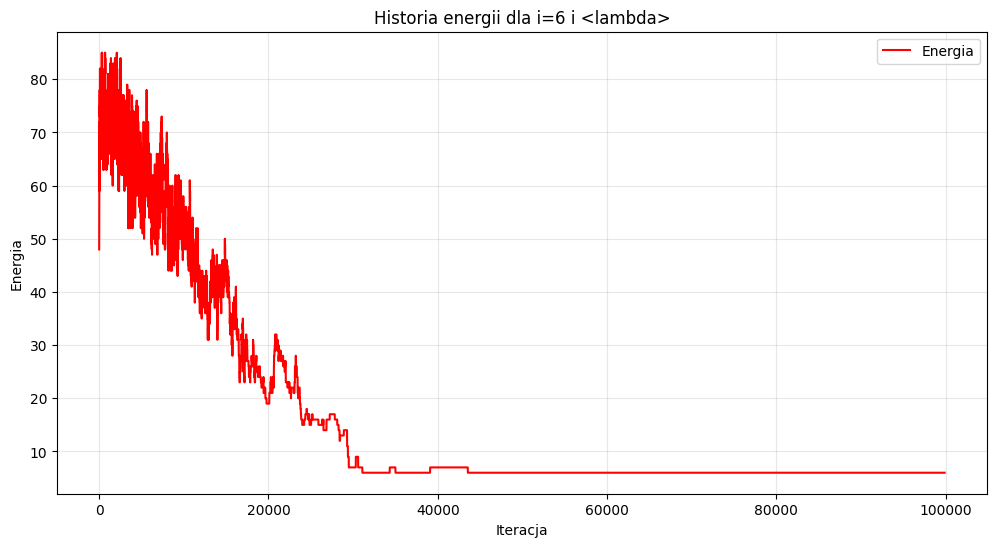

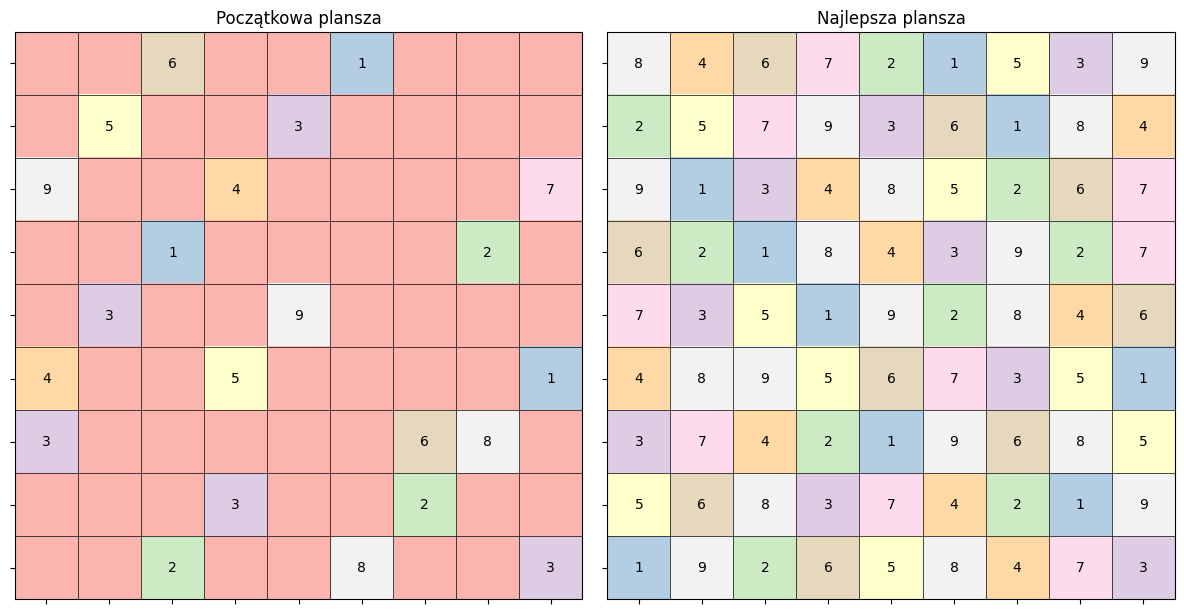

--------------------------------------------------
Sudoku nr 6 z 59 pustymi polami 
i: 6, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 2


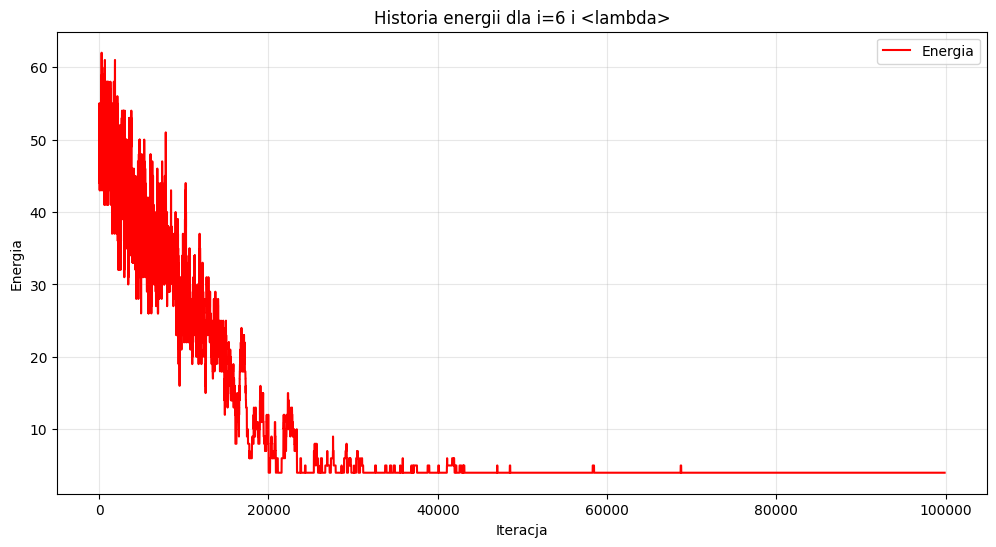

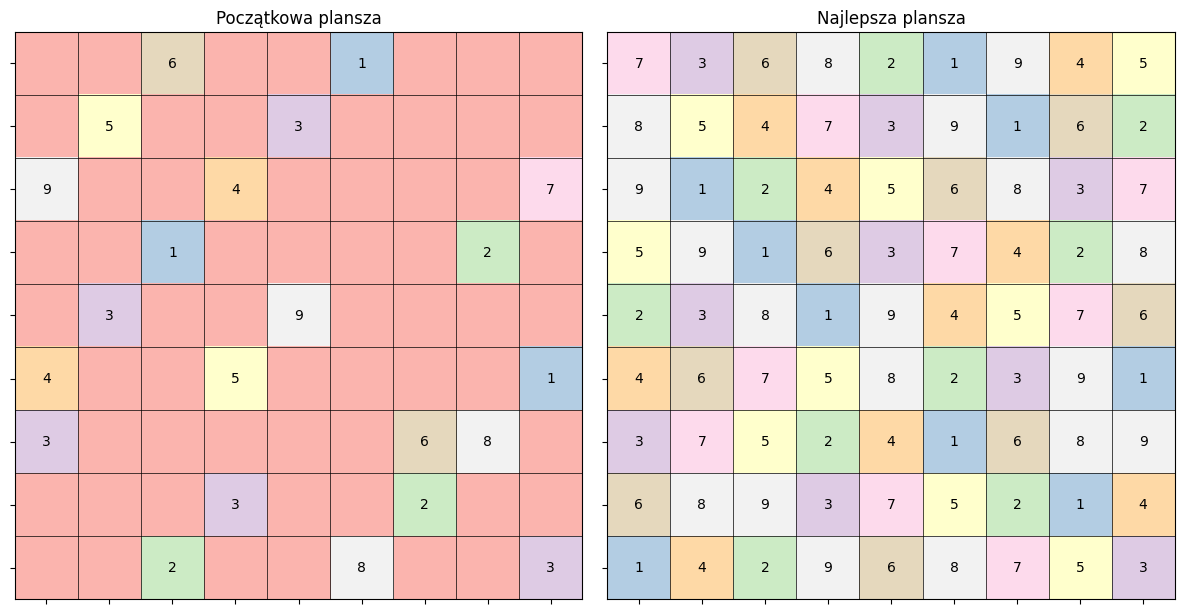

--------------------------------------------------
Sudoku nr 6 z 59 pustymi polami 
i: 6, cooling: <lambda>, iter_count: 69075, best_energy: 6, neigh_type: 1


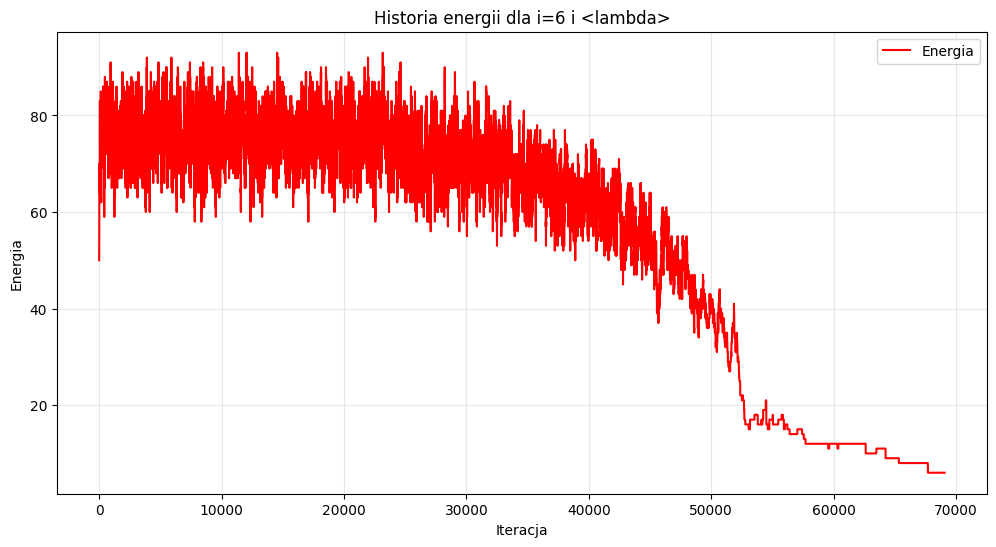

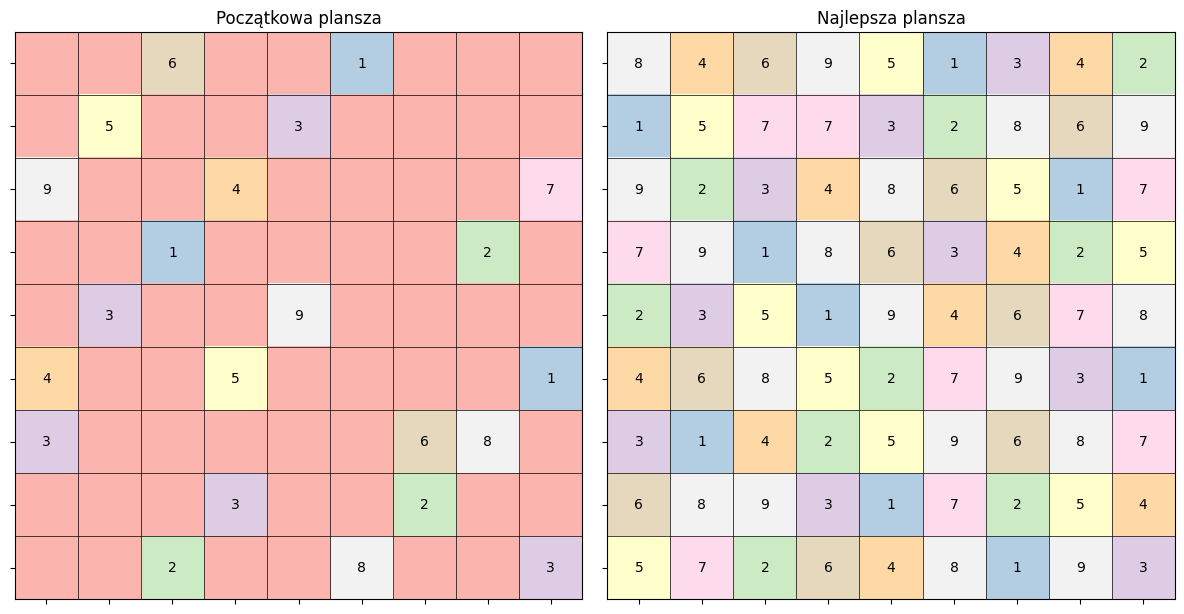

--------------------------------------------------
Sudoku nr 6 z 59 pustymi polami 
i: 6, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 2


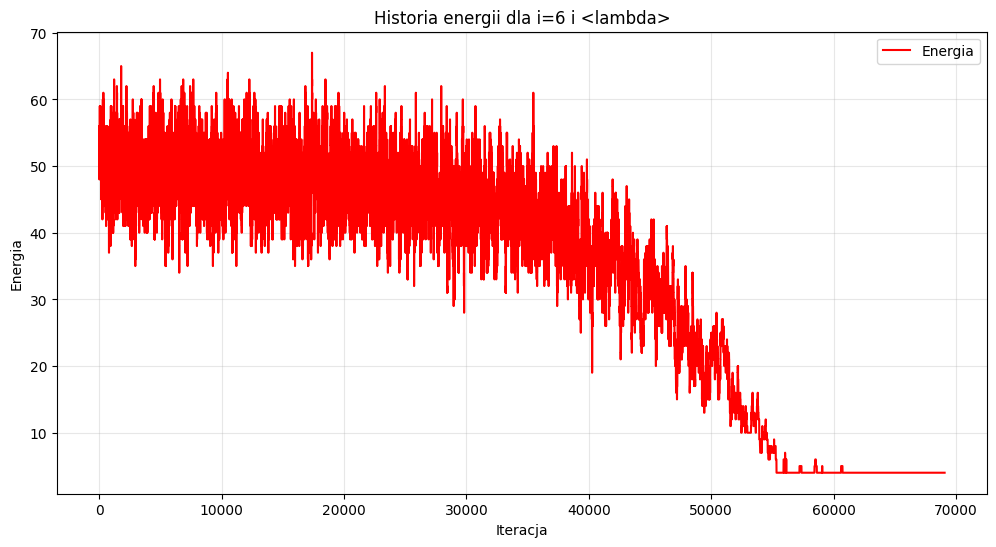

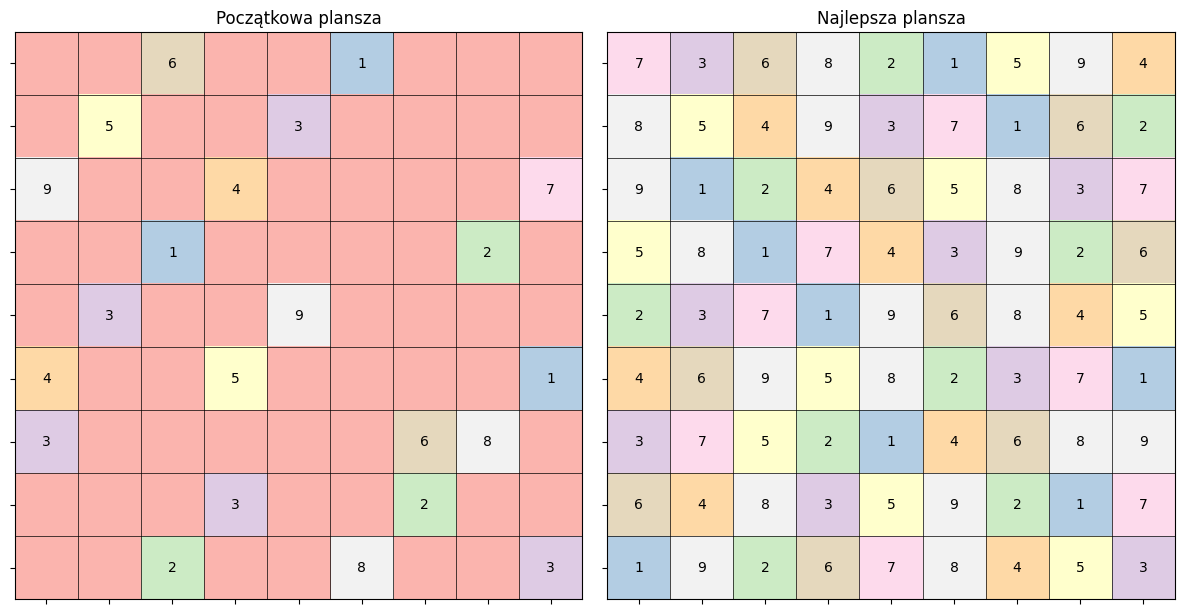

--------------------------------------------------
Sudoku nr 7 z 59 pustymi polami 
i: 7, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 1


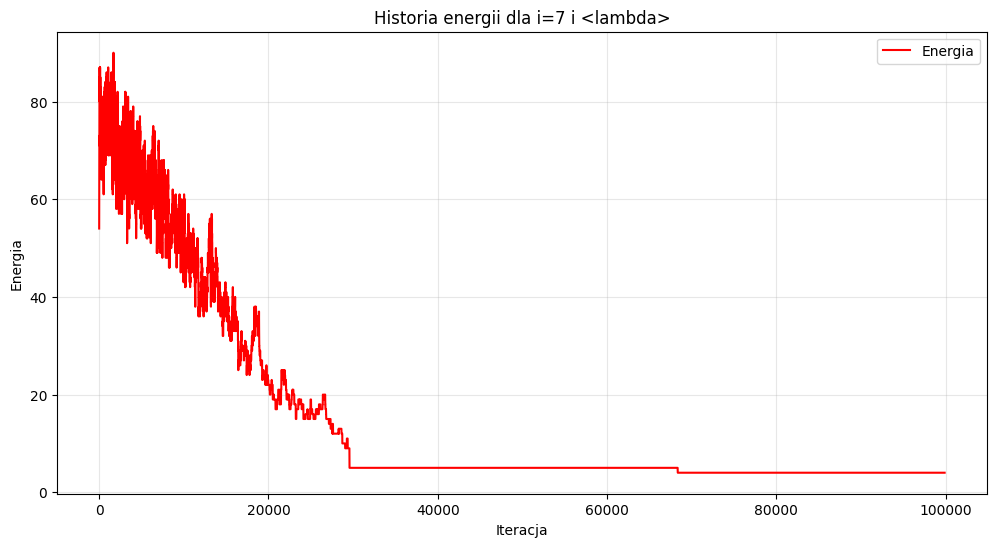

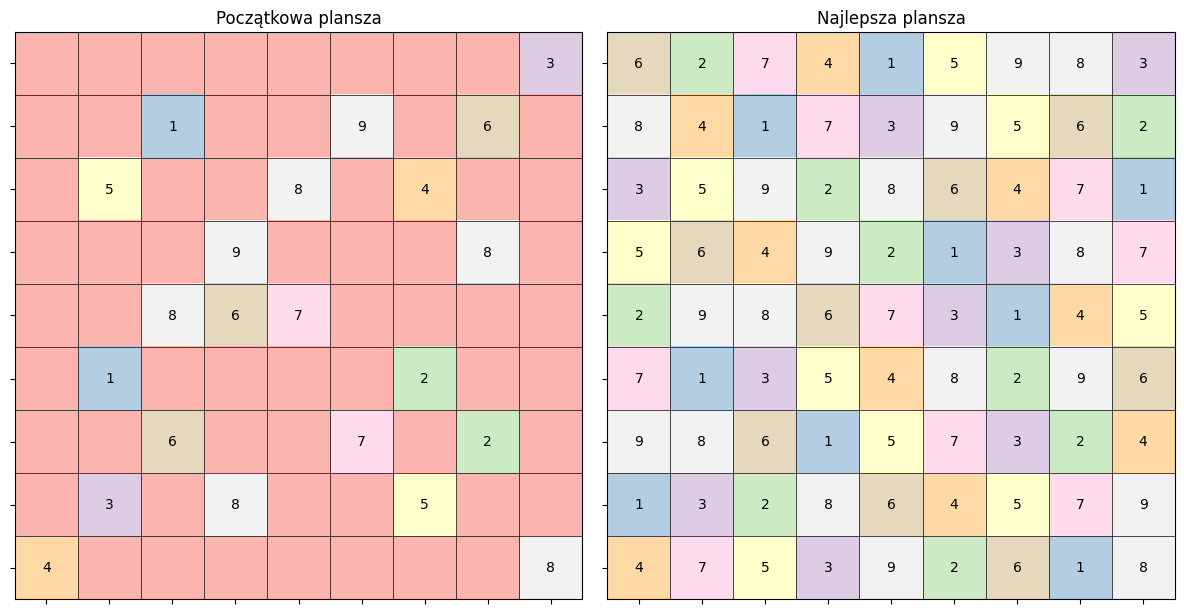

--------------------------------------------------
Sudoku nr 7 z 59 pustymi polami 
i: 7, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


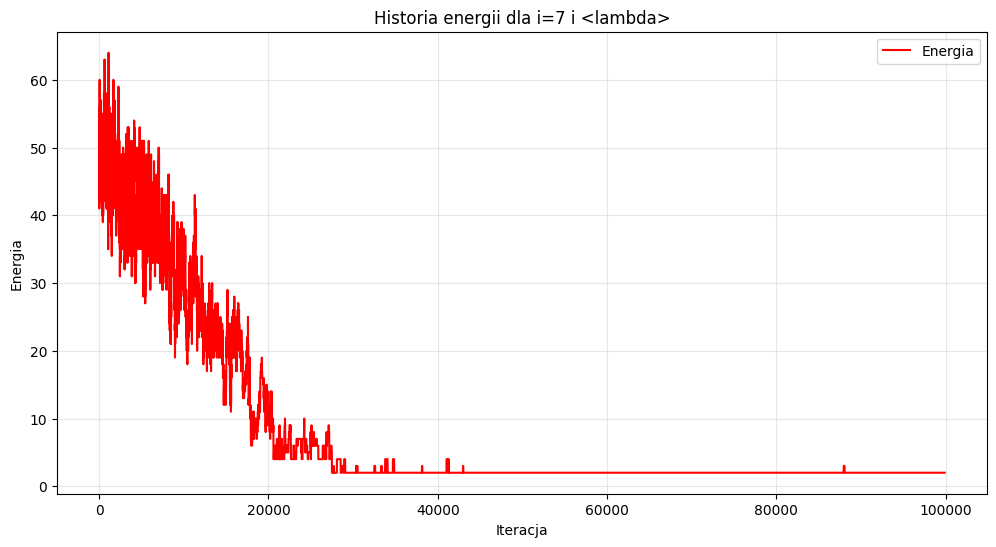

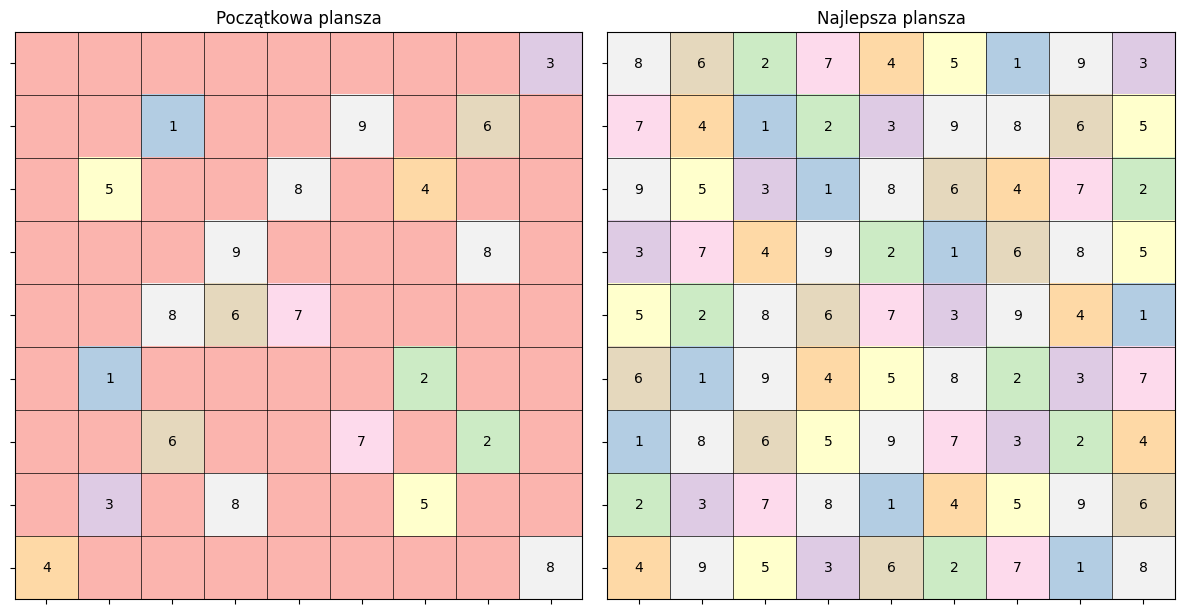

--------------------------------------------------
Sudoku nr 7 z 59 pustymi polami 
i: 7, cooling: <lambda>, iter_count: 69075, best_energy: 4, neigh_type: 1


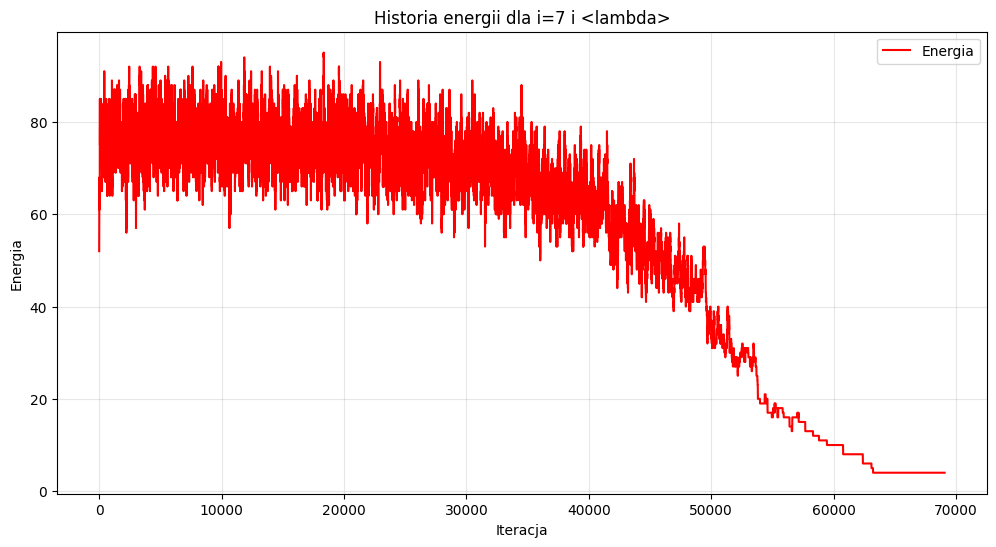

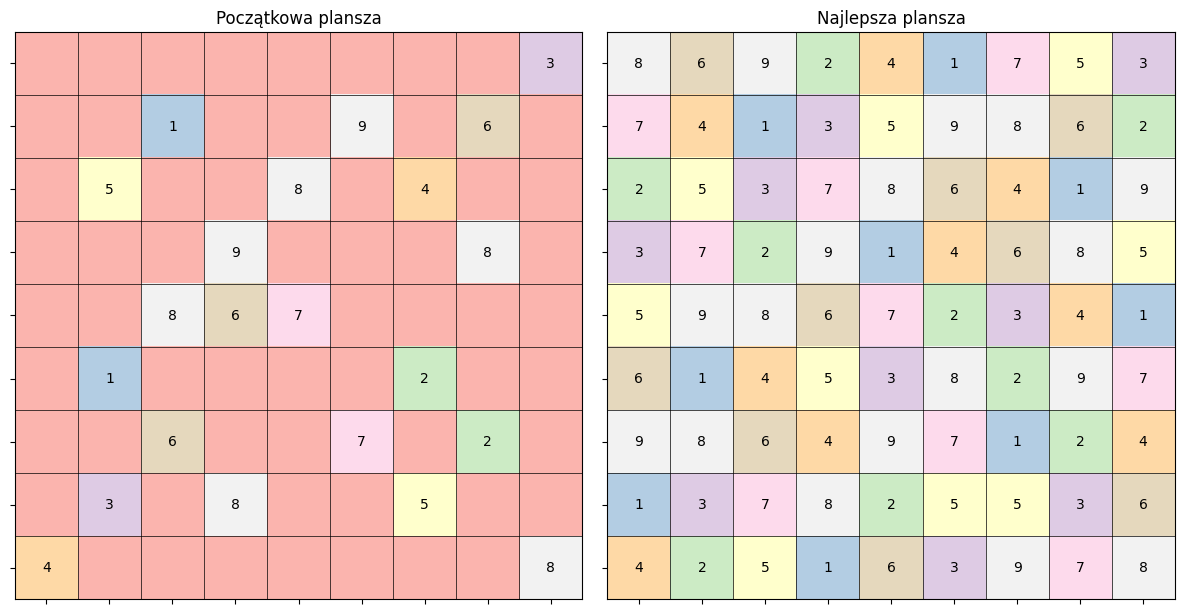

--------------------------------------------------
Sudoku nr 7 z 59 pustymi polami 
i: 7, cooling: <lambda>, iter_count: 69075, best_energy: 5, neigh_type: 2


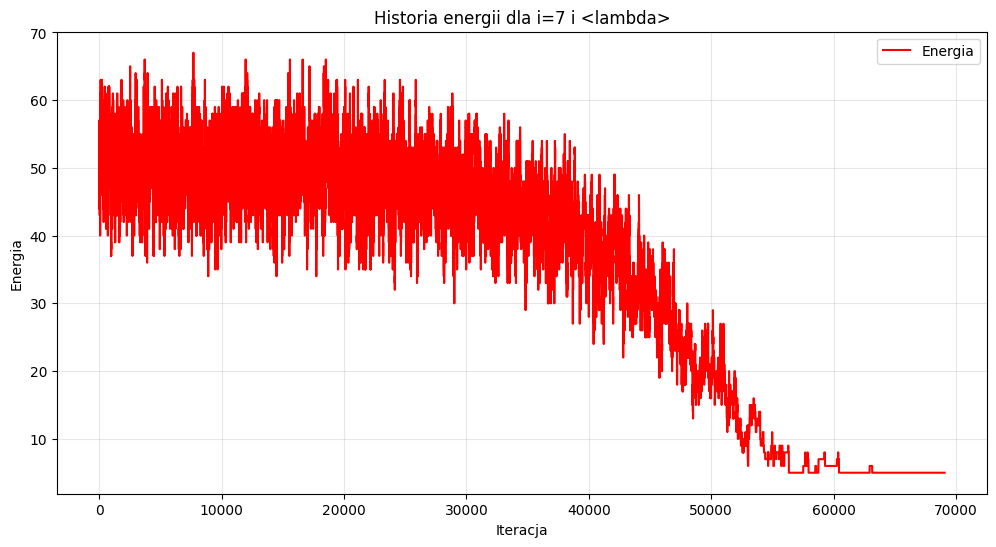

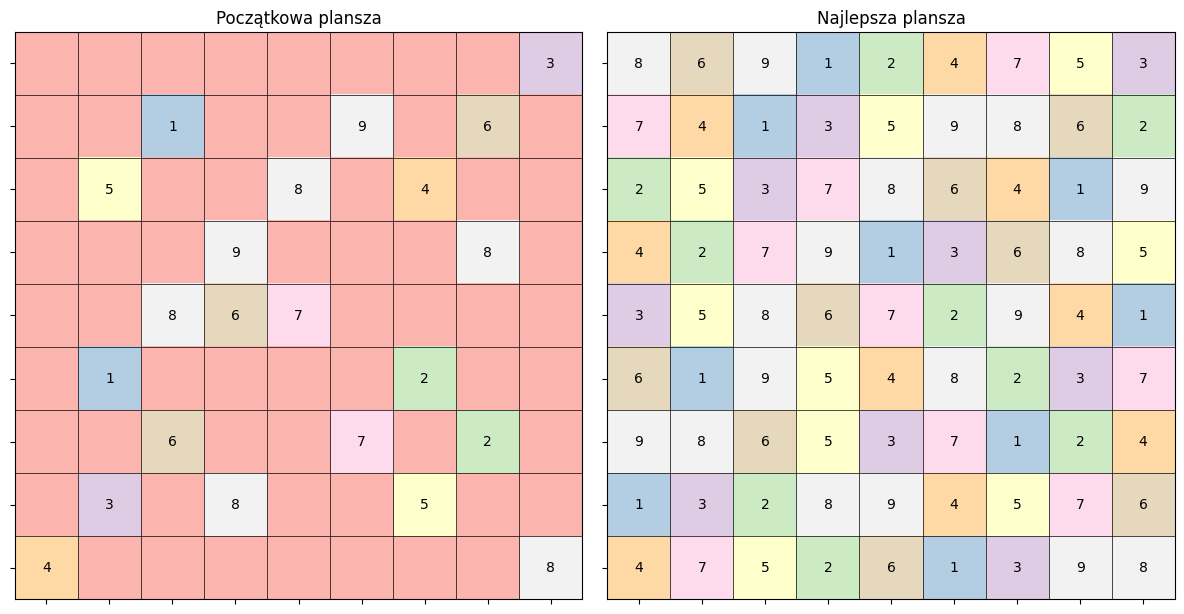

--------------------------------------------------
Sudoku nr 8 z 60 pustymi polami 
i: 8, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 1


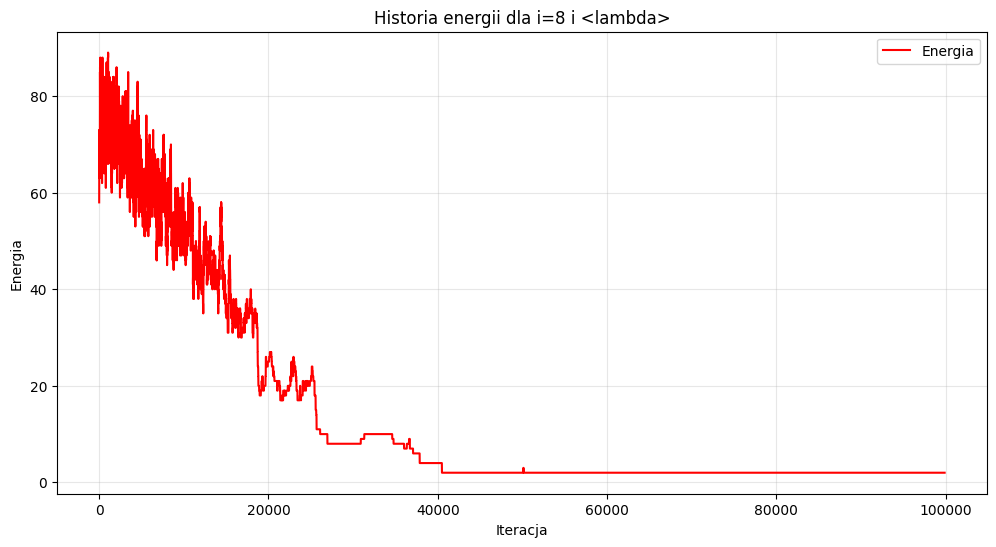

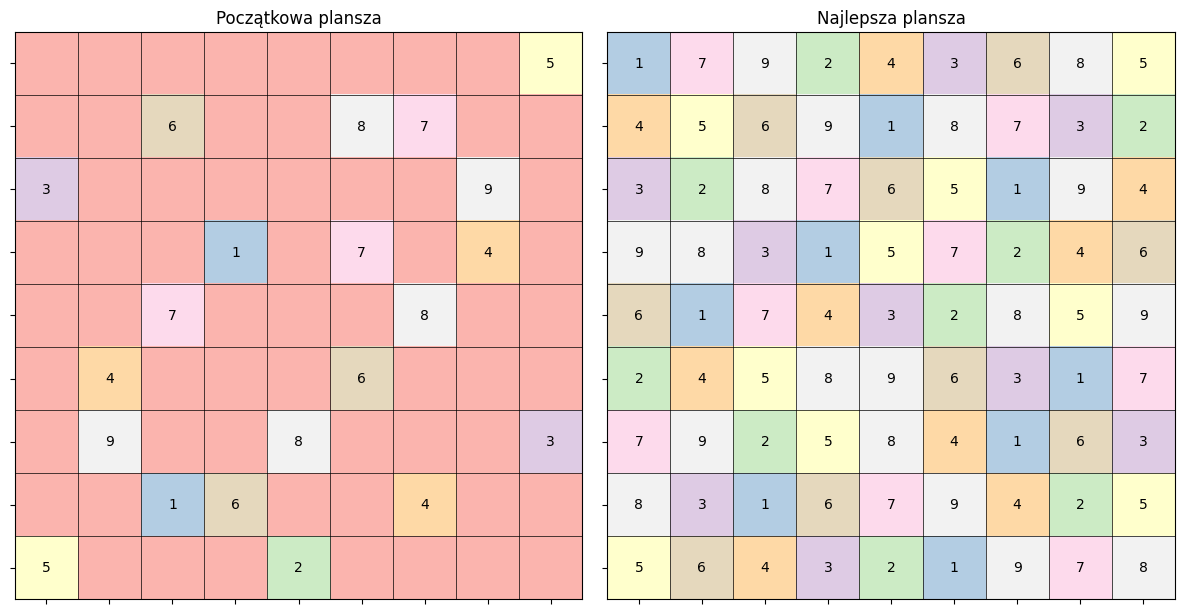

--------------------------------------------------
Sudoku nr 8 z 60 pustymi polami 
i: 8, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 2


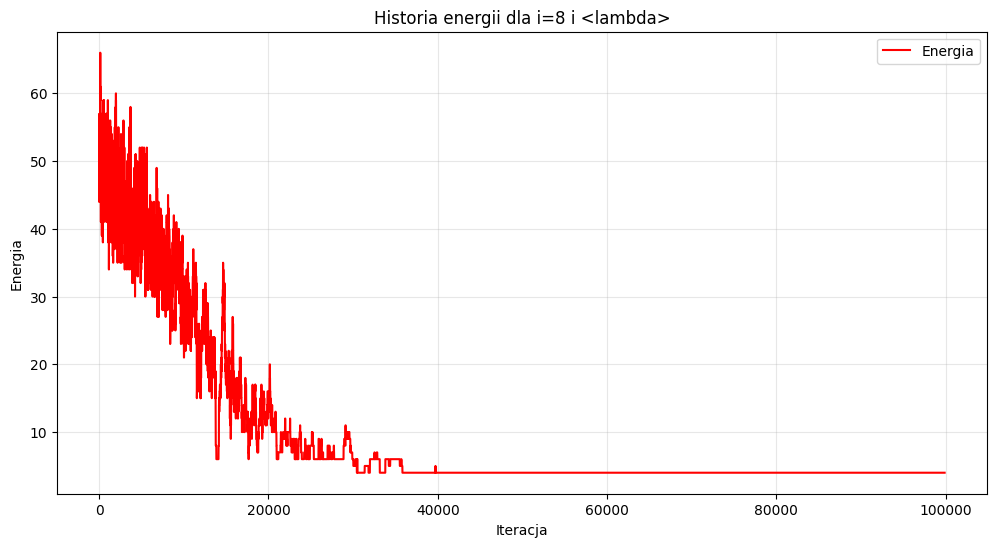

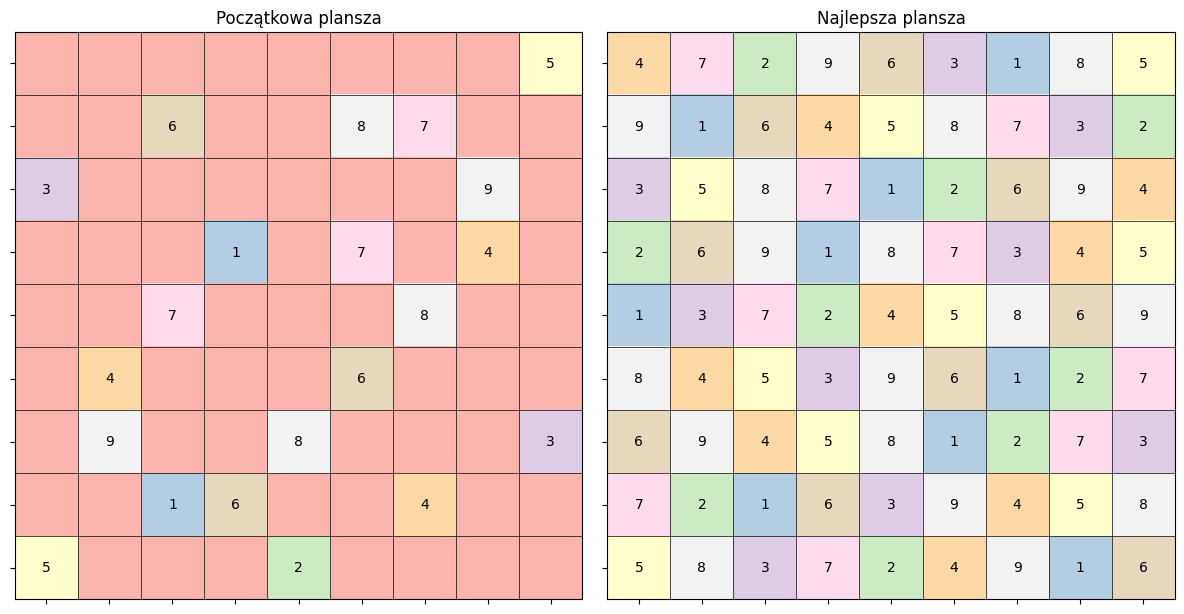

--------------------------------------------------
Sudoku nr 8 z 60 pustymi polami 
i: 8, cooling: <lambda>, iter_count: 69075, best_energy: 6, neigh_type: 1


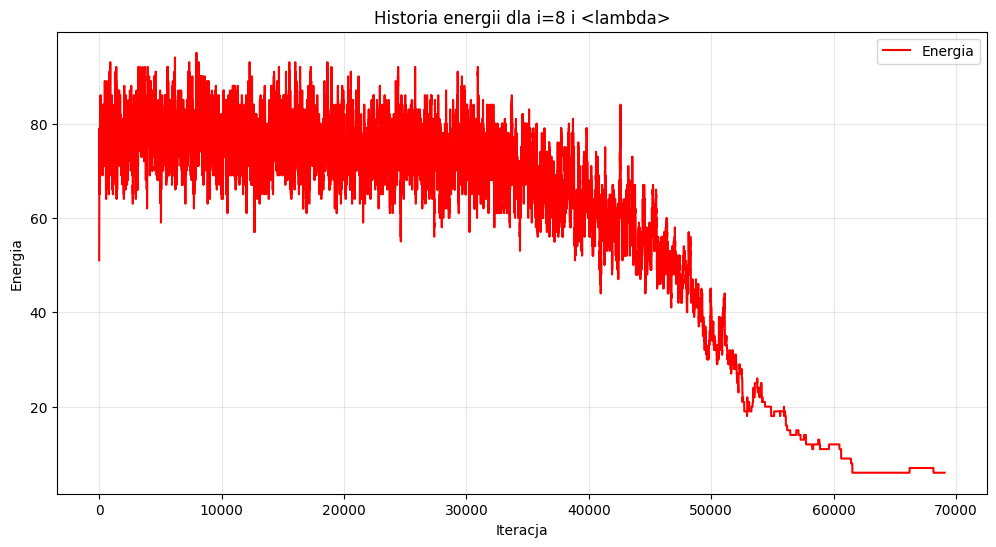

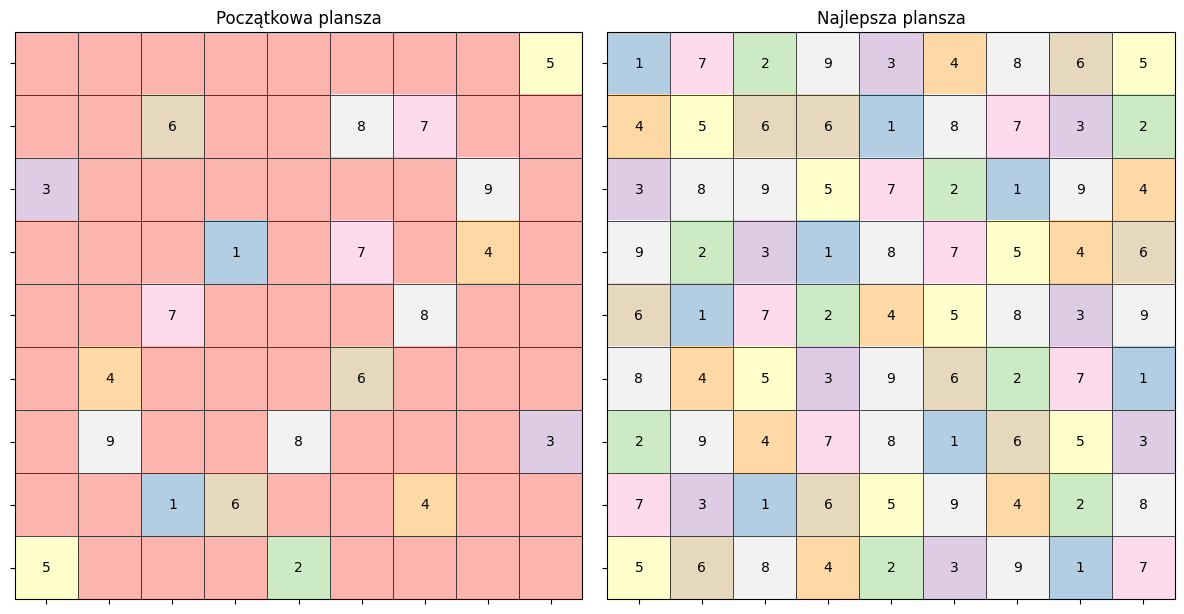

--------------------------------------------------
Sudoku nr 8 z 60 pustymi polami 
i: 8, cooling: <lambda>, iter_count: 69075, best_energy: 2, neigh_type: 2


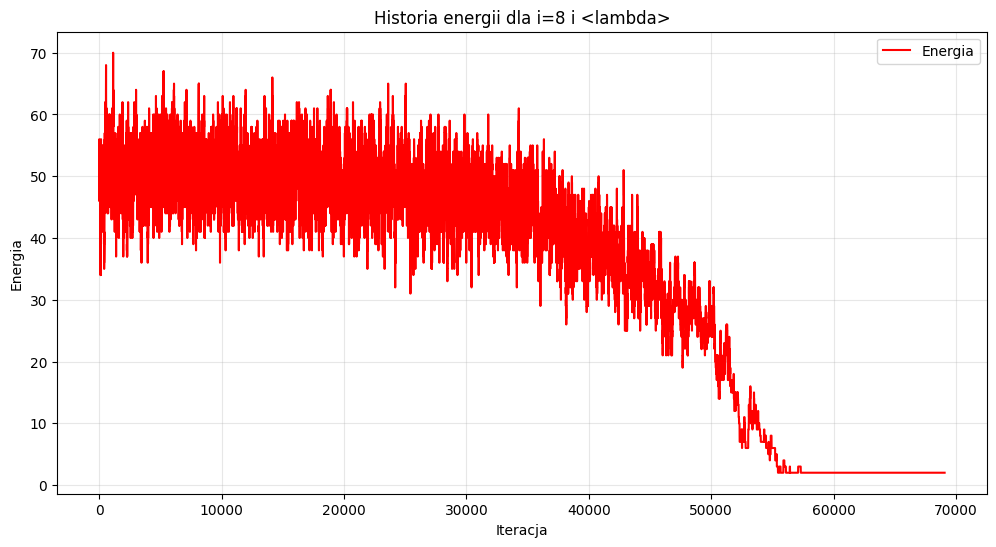

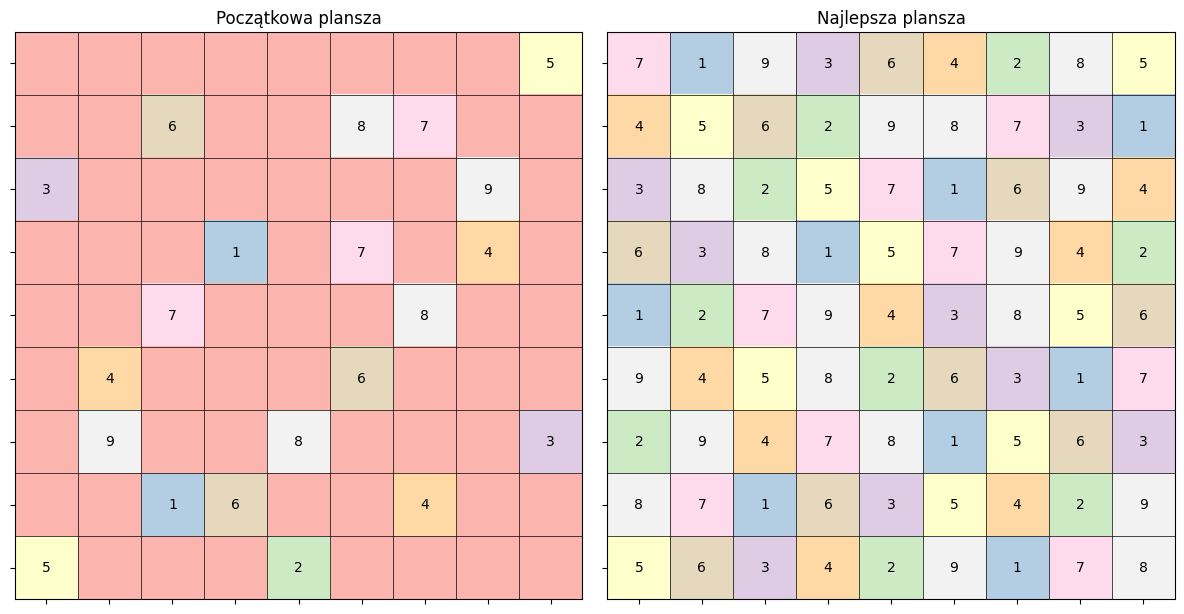

--------------------------------------------------
Sudoku nr 9 z 59 pustymi polami 
i: 9, cooling: <lambda>, iter_count: 99897, best_energy: 4, neigh_type: 1


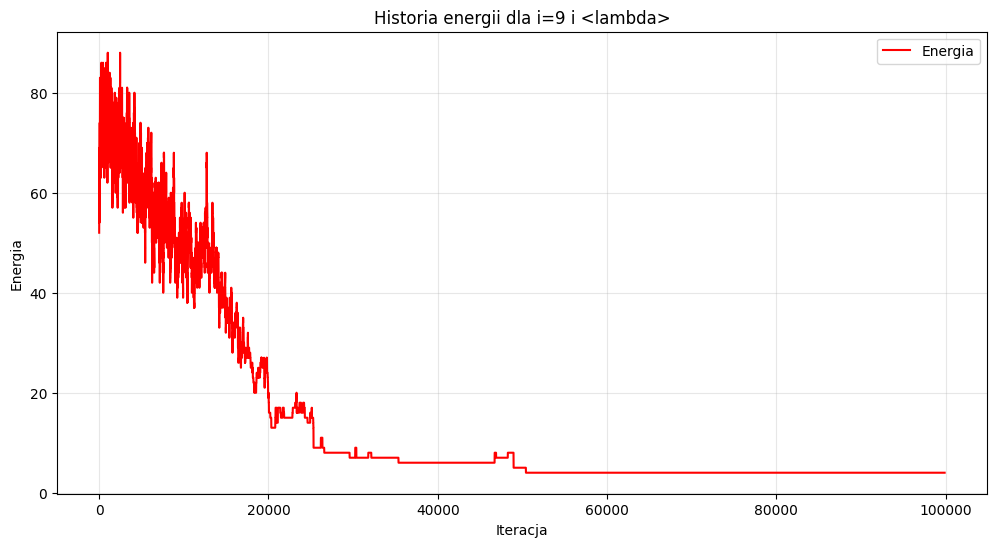

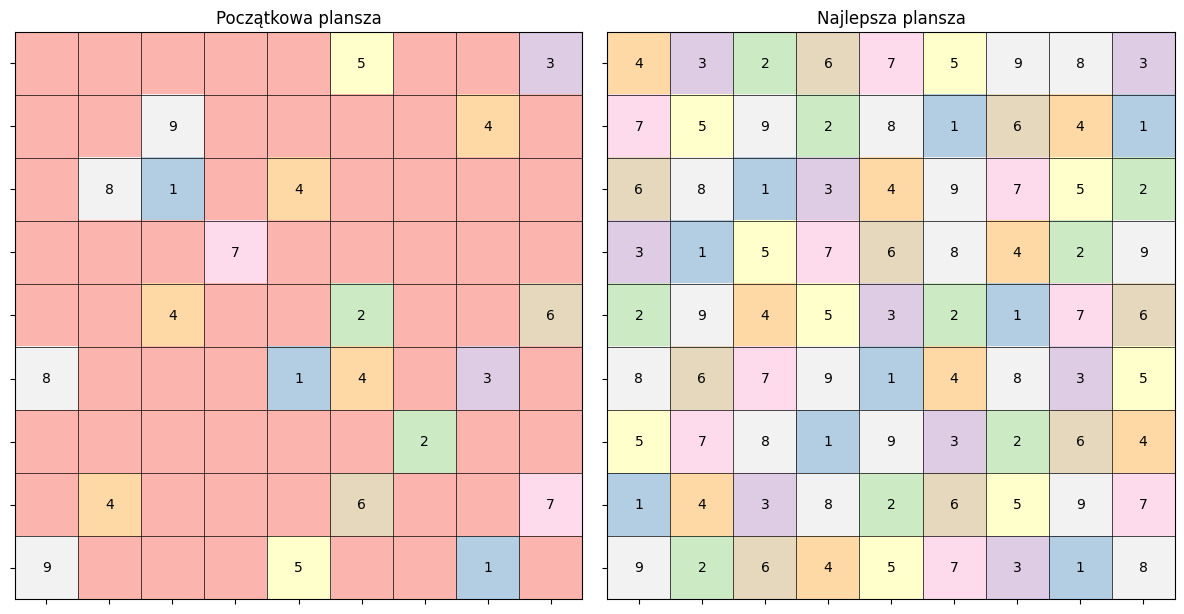

--------------------------------------------------
Sudoku nr 9 z 59 pustymi polami 
i: 9, cooling: <lambda>, iter_count: 99897, best_energy: 2, neigh_type: 2


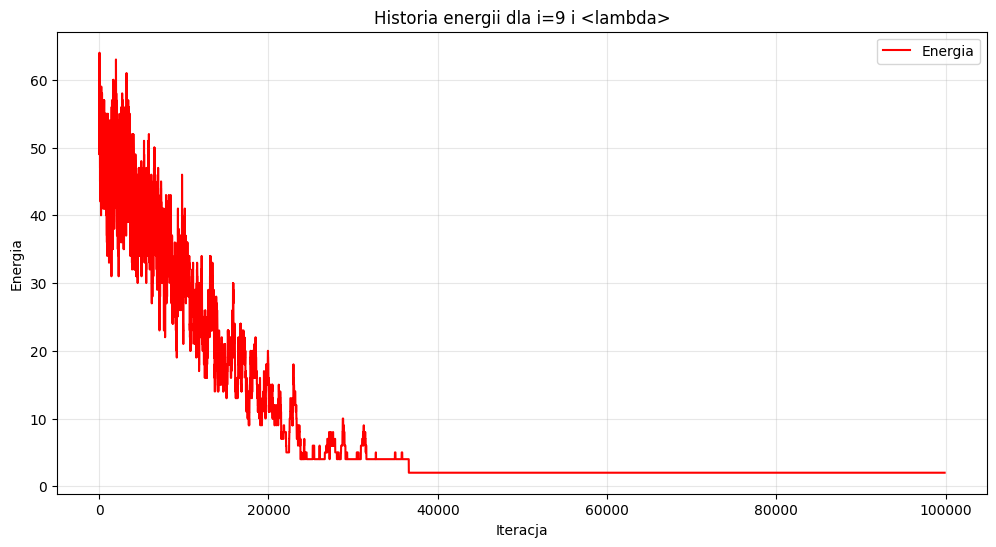

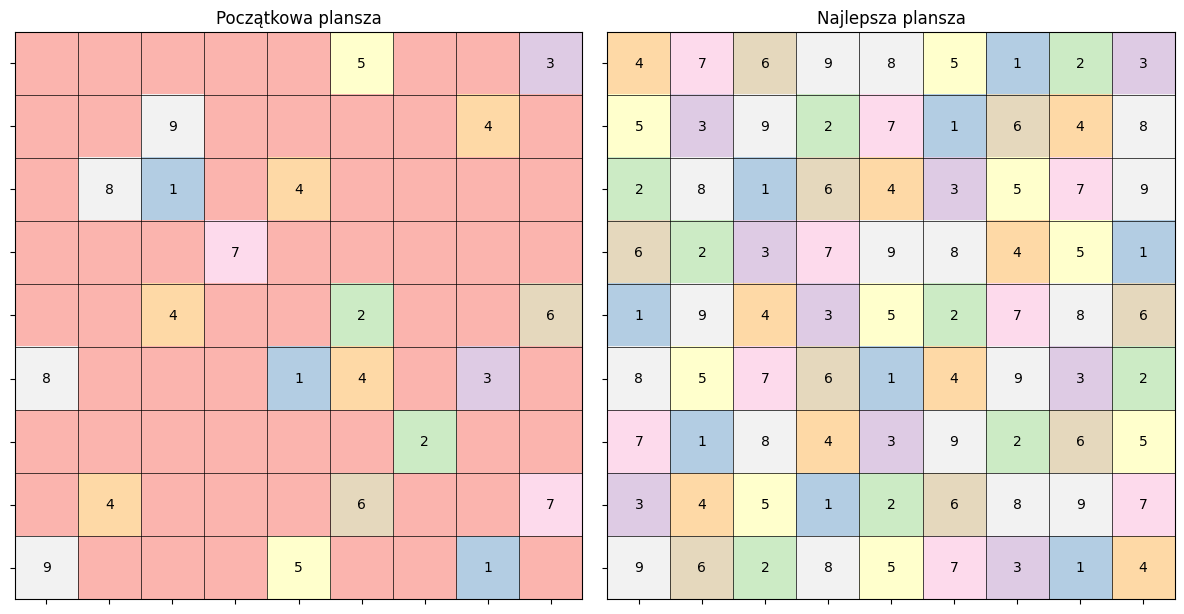

--------------------------------------------------
Sudoku nr 9 z 59 pustymi polami 
i: 9, cooling: <lambda>, iter_count: 69075, best_energy: 8, neigh_type: 1


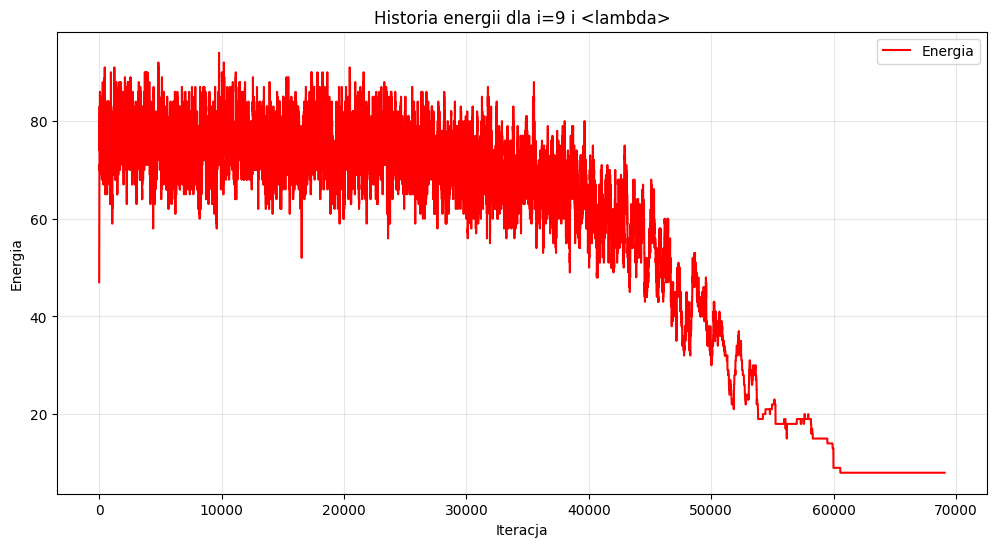

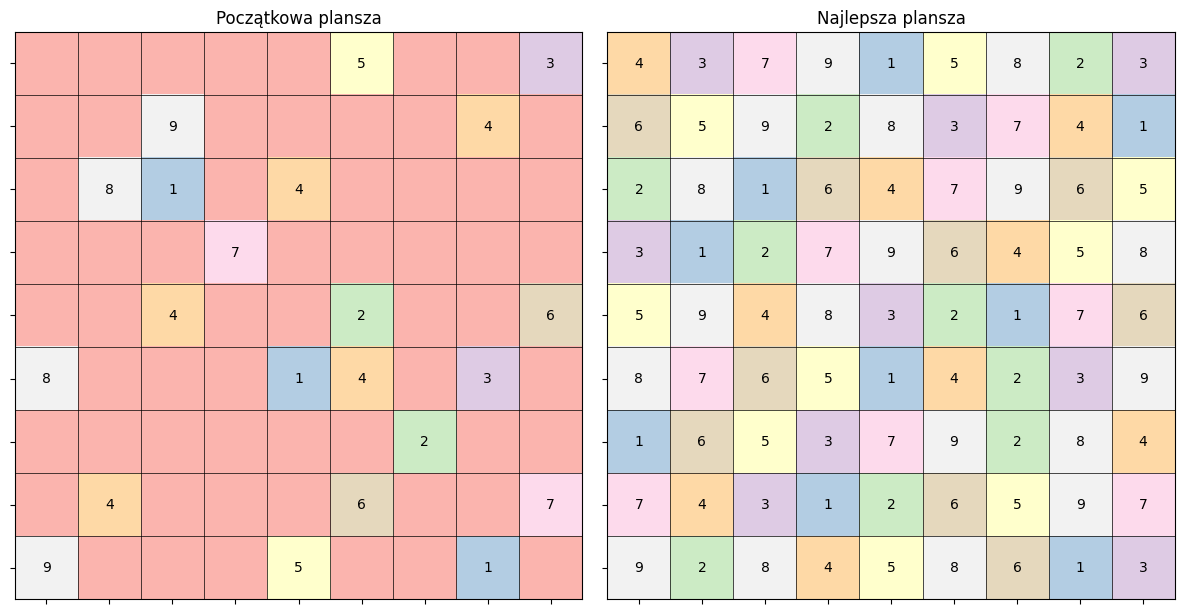

--------------------------------------------------
Sudoku nr 9 z 59 pustymi polami 
i: 9, cooling: <lambda>, iter_count: 69075, best_energy: 5, neigh_type: 2


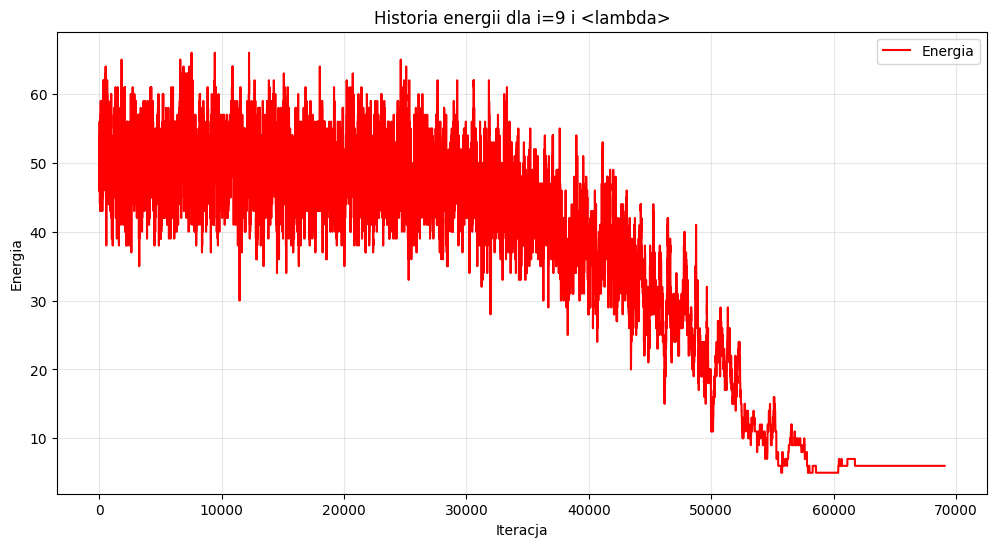

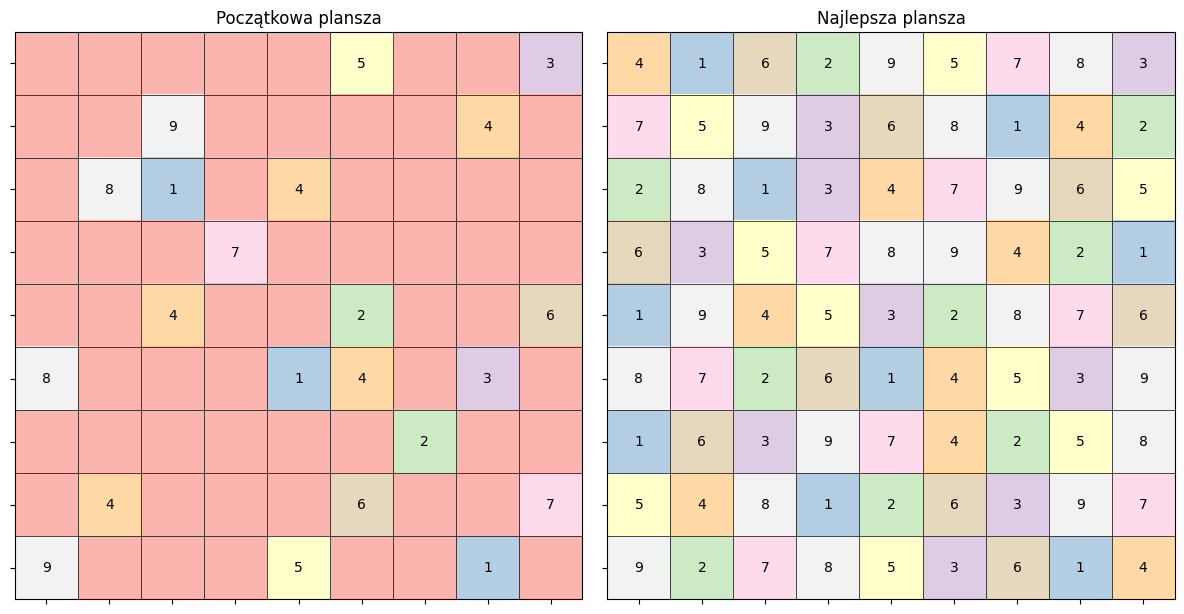

In [406]:
for i in range(10):
    for cooling in [exponential, geometric]:
        for neigh_type in [1,2]:
            if i < 5:
                sudoku, empty_pools = read_sudoku_from_json("sudoku.json", i)
            else:
                sudoku, empty_pools = read_sudoku("sudoku.txt", i)
            initial_sudoku = sudoku.copy()
            print("-" * 50)
            print(f"Sudoku nr {i} z {len(empty_pools)} pustymi polami ")

            fill_sudoku(sudoku)
            best, best_energy, iter_count, sudoku_history, energy_history = simulated_annealing(sudoku, empty_pools,
                                                                                                cooling, neigh_type=neigh_type)
            print(f"i: {i}, cooling: {cooling.__name__}, iter_count: {iter_count}, best_energy: {best_energy}, neigh_type: {neigh_type}")
            visualize_energy_history(energy_history, f"Historia energii dla i={i} i {cooling.__name__}",
                                     f"energy_history_{i}_{cooling.__name__}.png")
            display_initial_and_best(initial_sudoku, best)


"Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy." - dla znalezionych datasetow, gdzie prawie kazde ma podobna liczbe pustych pol, oraz znikoma liczbe udanych prob taki wykres nie wniosl by duzo wartosci.


"Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?" - nie

